In [8]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
# import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
# import pickle
import scipy.stats as stats
## Need to use metPy conda env
import metpy.calc as mpc
from metpy.units import units

import warnings
warnings.filterwarnings('ignore')


In [3]:

# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds



In [4]:
'''
Define a function to get the height of the PBL as the level with maximum d(var)/dz. 
Inputs:  A dataset with CAM output ('DS') and the variable to differentiate ('pbl_var')
Outputs: An array with boundary layer depth
'''
def PBLHasMaxDZ(DS, pbl_var): 
    # Convert HMGcamDS_all to height (nabbed from Rich's script)
    p0 = DS['P0'].values[0]
    
    plevm = DS['hyam']*p0 + DS['hybm']*DS['PS'].isel(lat=0,lon=0) # Mid level
    plevm.attrs['units'] = "Pa"

    # Height with standard atmosphere
    zlevm      = plevm
    zlevm_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm)) # Units of [m] after multiplied 
    zlevm      = plevm.copy(deep=True)
    zlevm[:,:] = zlevm_vals
    
    pvar        = DS[pbl_var].isel(lat=0,lon=0)
    pvar['lev'] = zlevm[0,:].values
    dvardz      = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

    dvardz.loc[:,200:]   = 0.  # Restrict to a specificheight region
    dvardz.loc[:,:3000.] = 0

    nT = np.shape(dvardz)[0]
    PBLdepth = np.full([nT], np.nan)

    for iT in range(nT):
        iLevs  = np.where((zlevm[iT,:]>=200) & (zlevm[iT,:]<=3000))[0]
        maxLev = np.where(dvardz[iT,iLevs]==np.nanmax(dvardz[iT,iLevs]))[0]
        PBLdepth[iT] = zlevm[iT,iLevs[maxLev[0]]]
    
    return PBLdepth

## Read in data


### Real surface 

In [5]:
## Read in CLM files 

# dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc/'
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_'

# This set uses theta, not theta_v; and adds outputs of rt'thv' and tau
dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_buoyancyTau_useTheta/'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTau_useTheta_'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTau_useTheta_'


yearStrings  = np.asarray(['2015','2016','2017','2018'])
dateEndFiles = np.asarray([ '-05-31-84585.nc',
                            '-06-09-56985.nc',
                            '-06-18-29385.nc',
                            '-06-27-01785.nc',
                            '-07-05-60585.nc',
                            '-07-14-32985.nc',
                            '-07-23-05385.nc',
                            '-07-31-64185.nc',
                            '-08-09-36585.nc',
                            '-08-18-08985.nc',
                            '-08-26-67785.nc' ])

fileCount=0
for iYr in range(len(yearStrings)): 
    fileStart_HMG = dataDir+caseName_HMG+yearStrings[iYr]+'jja.clm2.h0.'+yearStrings[iYr]
    fileStart_HTG = dataDir+caseName_HTG+yearStrings[iYr]+'jja.clm2.h0.'+yearStrings[iYr]
    
    fileStartPatch_HMG = dataDir+caseName_HMG+yearStrings[iYr]+'jja.clm2.h1.'+yearStrings[iYr]
    fileStartPatch_HTG = dataDir+caseName_HTG+yearStrings[iYr]+'jja.clm2.h1.'+yearStrings[iYr]
    
    fileStart_atm_HMG = dataDir+caseName_HMG+yearStrings[iYr]+'jja.cam.h0.'+yearStrings[iYr]
    fileStart_atm_HTG = dataDir+caseName_HTG+yearStrings[iYr]+'jja.cam.h0.'+yearStrings[iYr]
    
    for iFile in range(len(dateEndFiles)):
        fileName_HMG = fileStart_HMG+dateEndFiles[iFile]
        fileName_HTG = fileStart_HTG+dateEndFiles[iFile]
                                                                                          
        fileNamePatch_HMG = fileStartPatch_HMG+dateEndFiles[iFile]
        fileNamePatch_HTG = fileStartPatch_HTG+dateEndFiles[iFile]
        
        fileName_atm_HMG = fileStart_atm_HMG+dateEndFiles[iFile]
        fileName_atm_HTG = fileStart_atm_HTG+dateEndFiles[iFile]
        
        with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
            HMG_camDS = cesm_correct_time(HMG_camDS)
            HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex()
        with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
            HTG_camDS = cesm_correct_time(HTG_camDS)
            HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex()  
            
        with xr.open_dataset(fileName_HMG, decode_times=True) as HMG_clmDS: 
            HMG_clmDS['time'] = HTG_camDS['time']
        with xr.open_dataset(fileName_HTG, decode_times=True) as HTG_clmDS: 
            HTG_clmDS['time'] = HTG_camDS['time']
            
        with xr.open_dataset(fileNamePatch_HMG, decode_times=True) as HMG_clmPatchDS: 
            HMG_clmPatchDS['time'] = HTG_camDS['time']
        with xr.open_dataset(fileNamePatch_HTG, decode_times=True) as HTG_clmPatchDS: 
            HTG_clmPatchDS['time'] = HTG_camDS['time']       
        
        # Discard the first two days if iFile == 0  
        if iFile==0:
            iTimeStart   = np.where(HMG_clmDS.time.values >= (HMG_clmDS.time.values[0] + np.timedelta64(2,'D')))[0]
            timeArr      = np.arange(iTimeStart[0], len(HMG_clmDS.time.values))

            HTG_camDS      = HTG_camDS.isel(time=timeArr)
            HMG_camDS      = HMG_camDS.isel(time=timeArr)
            HTG_clmDS      = HTG_clmDS.isel(time=timeArr)
            HMG_clmDS      = HMG_clmDS.isel(time=timeArr)
            HTG_clmPatchDS = HTG_clmPatchDS.isel(time=timeArr)
            HMG_clmPatchDS = HMG_clmPatchDS.isel(time=timeArr)

        if fileCount==0:
            HTGcamDS_realSfc = HTG_camDS
            HMGcamDS_realSfc = HMG_camDS
            
            HTGclmDS_realSfc = HTG_clmDS
            HMGclmDS_realSfc = HMG_clmDS
            
            HTGclmDS_realSfcPatch = HTG_clmPatchDS
            HMGclmDS_realSfcPatch = HMG_clmPatchDS
            
        else: 
            HTGcamDS_realSfc = xr.concat([HTGcamDS_realSfc,HTG_camDS], dim='time')
            HMGcamDS_realSfc = xr.concat([HMGcamDS_realSfc,HMG_camDS], dim='time')
            
            HTGclmDS_realSfc = xr.concat([HTGclmDS_realSfc,HTG_clmDS], dim='time', data_vars='minimal')
            HMGclmDS_realSfc = xr.concat([HMGclmDS_realSfc,HMG_clmDS], dim='time', data_vars='minimal')
            
            HTGclmDS_realSfcPatch = xr.concat([HTGclmDS_realSfcPatch,HTG_clmPatchDS], dim='time', data_vars='minimal')
            HMGclmDS_realSfcPatch = xr.concat([HMGclmDS_realSfcPatch,HMG_clmPatchDS], dim='time', data_vars='minimal')
        
        fileCount = fileCount+1
        print('Done with file %i of %i '% (fileCount,len(yearStrings)*len(dateEndFiles)))



Done with file 1 of 44 
Done with file 2 of 44 
Done with file 3 of 44 
Done with file 4 of 44 
Done with file 5 of 44 
Done with file 6 of 44 
Done with file 7 of 44 
Done with file 8 of 44 
Done with file 9 of 44 
Done with file 10 of 44 
Done with file 11 of 44 
Done with file 12 of 44 
Done with file 13 of 44 
Done with file 14 of 44 
Done with file 15 of 44 
Done with file 16 of 44 
Done with file 17 of 44 
Done with file 18 of 44 
Done with file 19 of 44 
Done with file 20 of 44 
Done with file 21 of 44 
Done with file 22 of 44 
Done with file 23 of 44 
Done with file 24 of 44 
Done with file 25 of 44 
Done with file 26 of 44 
Done with file 27 of 44 
Done with file 28 of 44 
Done with file 29 of 44 
Done with file 30 of 44 
Done with file 31 of 44 
Done with file 32 of 44 
Done with file 33 of 44 
Done with file 34 of 44 
Done with file 35 of 44 
Done with file 36 of 44 
Done with file 37 of 44 
Done with file 38 of 44 
Done with file 39 of 44 
Done with file 40 of 44 
Done with

NameError: name 'HTGcamDS_all' is not defined

In [9]:
## Add evaporative fraction to DS 
HTG_EF = HTGcamDS_realSfc.LHFLX.values / (HTGcamDS_realSfc.LHFLX.values + HTGcamDS_realSfc.SHFLX.values)
HMG_EF = HMGcamDS_realSfc.LHFLX.values / (HMGcamDS_realSfc.LHFLX.values + HTGcamDS_realSfc.SHFLX.values)

HTGcamDS_realSfc['EvapFraction'] = (('time'), np.squeeze(HTG_EF))
HMGcamDS_realSfc['EvapFraction'] = (('time'), np.squeeze(HMG_EF))

## Define the actual vertical velocity skew, not just the third order moment 
skw_W_HTG = HTGcamDS_realSfc.WP3_CLUBB.values / ((HTGcamDS_realSfc.WP2_CLUBB.values)**1.5)
skw_W_HMG = HMGcamDS_realSfc.WP3_CLUBB.values / ((HMGcamDS_realSfc.WP2_CLUBB.values)**1.5)

HTGcamDS_realSfc['Skw_W'] = (('time','ilev'), np.squeeze(skw_W_HTG))
HMGcamDS_realSfc['Skw_W'] = (('time','ilev'), np.squeeze(skw_W_HMG))


## Steps to get PBL 

## Get *potential* temperature, not just T 

# So first, get actual pressures 
p0       = HTGcamDS_realSfc['P0'].values[0]
plevmHTG = HTGcamDS_realSfc['hyam']*p0 + HTGcamDS_realSfc['hybm']*HTGcamDS_realSfc['PS'].isel(lat=0,lon=0) # Mid level
plevmHTG.attrs['units'] = "Pa"

p0       = HMGcamDS_realSfc['P0'].values[0]
plevmHMG = HMGcamDS_realSfc['hyam']*p0 + HMGcamDS_realSfc['hybm']*HMGcamDS_realSfc['PS'].isel(lat=0,lon=0) # Mid level
plevmHMG.attrs['units'] = "Pa"

HTG_theta = np.asarray(mpc.potential_temperature(plevmHTG * units.pascals, HTGcamDS_realSfc['T'] * units.kelvin))
HMG_theta = np.asarray(mpc.potential_temperature(plevmHMG * units.pascals, HMGcamDS_realSfc['T'] * units.kelvin))

# Add to existing DS
HTGcamDS_realSfc['theta'] = (('time','lev','lat','lon'), HTG_theta)
HMGcamDS_realSfc['theta'] = (('time','lev','lat','lon'), HMG_theta)


# Height with standard atmosphere
zlevmHTG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevmHTG)) # Units of [m] after multiplied 
zlevmHTG      = plevmHTG.copy(deep=True)
zlevmHTG[:,:] = zlevmHTG_vals

zlevmHMG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevmHMG)) # Units of [m] after multiplied 
zlevmHMG      = plevmHMG.copy(deep=True)
zlevmHMG[:,:] = zlevmHMG_vals

# Now compute the BL depth and save it to the larger CAM datasets 
PBLdepth_hmg = PBLHasMaxDZ(HMGcamDS_realSfc, 'theta')
PBLdepth_htg = PBLHasMaxDZ(HTGcamDS_realSfc, 'theta')

# Add above to each dataset
HMGcamDS_realSfc['PBLdepth'] = (('time'), PBLdepth_hmg)
HTGcamDS_realSfc['PBLdepth'] = (('time'), PBLdepth_htg)

### Artificial surface (and multipliers)

In [10]:
# This version also outputs the buoyancy term, rt'thv', tau, and uses theta (not theta_v) for HTG additions
dataDirBase   = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/artificialSfc_buoyancyTau_useTheta/'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_plusBuoyancyTau_useTheta_'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_plusBuoyancyTau_useTheta_'

dataDirHTGp5   = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/artificialSfc_HTGtimes0p5/'
caseName_HTGp5 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc0p5htg_plusBuoyancyTau_useTheta_'

dataDirHTGp25   = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/artificialSfc_HTGtimes0p25/'
caseName_HTGp25 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc0p25htg_plusBuoyancyTau_useTheta_'


yearStrings  = np.asarray(['2015','2016','2017','2018'])
dateEndFiles = np.asarray([ '-05-31-84585.nc',
                            '-06-09-56985.nc',
                            '-06-18-29385.nc',
                            '-06-27-01785.nc',
                            '-07-05-60585.nc',
                            '-07-14-32985.nc',
                            '-07-23-05385.nc',
                            '-07-31-64185.nc',
                            '-08-09-36585.nc',
                            '-08-18-08985.nc',
                            '-08-26-67785.nc' ])

fileCount=0
for iYr in range(len(yearStrings)): 
    fileStart_HMG = dataDirBase+caseName_HMG+yearStrings[iYr]+'jja.clm2.h0.'+yearStrings[iYr]
    fileStart_HTG = dataDirBase+caseName_HTG+yearStrings[iYr]+'jja.clm2.h0.'+yearStrings[iYr]
    
    fileStartPatch_HMG = dataDirBase+caseName_HMG+yearStrings[iYr]+'jja.clm2.h1.'+yearStrings[iYr]
    fileStartPatch_HTG = dataDirBase+caseName_HTG+yearStrings[iYr]+'jja.clm2.h1.'+yearStrings[iYr]
    
    fileStart_atm_HMG = dataDirBase+caseName_HMG+yearStrings[iYr]+'jja.cam.h0.'+yearStrings[iYr]
    fileStart_atm_HTG = dataDirBase+caseName_HTG+yearStrings[iYr]+'jja.cam.h0.'+yearStrings[iYr]
    
    
    ## Read in multiplier versions too 
    fileStart_atm_HTGp5  = dataDirHTGp5+caseName_HTGp5+yearStrings[iYr]+'jja.cam.h0.'+yearStrings[iYr]
    fileStart_atm_HTGp25 = dataDirHTGp25+caseName_HTGp25+yearStrings[iYr]+'jja.cam.h0.'+yearStrings[iYr]
    
    fileStart_lnd_HTGp5  = dataDirHTGp5+caseName_HTGp5+yearStrings[iYr]+'jja.clm2.h0.'+yearStrings[iYr]
    fileStart_lnd_HTGp25 = dataDirHTGp25+caseName_HTGp25+yearStrings[iYr]+'jja.clm2.h0.'+yearStrings[iYr]
    
    
    
    for iFile in range(len(dateEndFiles)):
        fileName_HMG = fileStart_HMG+dateEndFiles[iFile]
        fileName_HTG = fileStart_HTG+dateEndFiles[iFile]
                                                                                          
        fileNamePatch_HMG = fileStartPatch_HMG+dateEndFiles[iFile]
        fileNamePatch_HTG = fileStartPatch_HTG+dateEndFiles[iFile]
        
        fileName_atm_HMG = fileStart_atm_HMG+dateEndFiles[iFile]
        fileName_atm_HTG = fileStart_atm_HTG+dateEndFiles[iFile]
        
        
        with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
            HMG_camDS = cesm_correct_time(HMG_camDS)
            HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex()
        with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
            HTG_camDS = cesm_correct_time(HTG_camDS)
            HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex()  
            
        with xr.open_dataset(fileName_HMG, decode_times=True) as HMG_clmDS: 
            HMG_clmDS['time'] = HTG_camDS['time']
        with xr.open_dataset(fileName_HTG, decode_times=True) as HTG_clmDS: 
            HTG_clmDS['time'] = HTG_camDS['time']
            
        with xr.open_dataset(fileNamePatch_HMG, decode_times=True) as HMG_clmPatchDS: 
            HMG_clmPatchDS['time'] = HTG_camDS['time']
        with xr.open_dataset(fileNamePatch_HTG, decode_times=True) as HTG_clmPatchDS: 
            HTG_clmPatchDS['time'] = HTG_camDS['time']   
            
            
        ## Multiplier versions 
        fileName_atm_HTGp5  = fileStart_atm_HTGp5+dateEndFiles[iFile]     
        fileName_atm_HTGp25 = fileStart_atm_HTGp25+dateEndFiles[iFile] 
        
        fileName_lnd_HTGp5  = fileStart_lnd_HTGp5+dateEndFiles[iFile]     
        fileName_lnd_HTGp25 = fileStart_lnd_HTGp25+dateEndFiles[iFile]
        
        with xr.open_dataset(fileName_atm_HTGp5, decode_times=False) as HTGp5_camDS:
            HTGp5_camDS = cesm_correct_time(HTGp5_camDS)
            HTGp5_camDS['time'] = HTGp5_camDS.indexes['time'].to_datetimeindex()
        with xr.open_dataset(fileName_atm_HTGp25, decode_times=False) as HTGp25_camDS:
            HTGp25_camDS = cesm_correct_time(HTGp25_camDS)
            HTGp25_camDS['time'] = HTGp25_camDS.indexes['time'].to_datetimeindex()
            
        with xr.open_dataset(fileName_lnd_HTGp5, decode_times=True) as HTGp5_clmDS: 
            HTGp5_clmDS['time'] = HTGp5_camDS['time']
        with xr.open_dataset(fileName_lnd_HTGp25, decode_times=True) as HTGp25_clmDS: 
            HTGp25_clmDS['time'] = HTGp25_camDS['time']
        
        
        
        
        # Discard the first two days if iFile == 0  
        if iFile==0:
            iTimeStart   = np.where(HMG_clmDS.time.values >= (HMG_clmDS.time.values[0] + np.timedelta64(2,'D')))[0]
            timeArr      = np.arange(iTimeStart[0], len(HMG_clmDS.time.values))

            HTG_camDS      = HTG_camDS.isel(time=timeArr)
            HMG_camDS      = HMG_camDS.isel(time=timeArr)
            HTG_clmDS      = HTG_clmDS.isel(time=timeArr)
            HMG_clmDS      = HMG_clmDS.isel(time=timeArr)
            HTG_clmPatchDS = HTG_clmPatchDS.isel(time=timeArr)
            HMG_clmPatchDS = HMG_clmPatchDS.isel(time=timeArr)
            
            ## Multiplier versions
            HTGp5_camDS    = HTGp5_camDS.isel(time=timeArr)
            HTGp25_camDS   = HTGp25_camDS.isel(time=timeArr)
            HTGp5_clmDS    = HTGp5_clmDS.isel(time=timeArr)
            HTGp25_clmDS   = HTGp25_clmDS.isel(time=timeArr)

        if fileCount==0:
            HTGcamDS_art = HTG_camDS
            HMGcamDS_art = HMG_camDS
            
            HTGclmDS_art = HTG_clmDS
            HMGclmDS_art = HMG_clmDS
            
            HTGclmDS_artPatch = HTG_clmPatchDS
            HMGclmDS_artPatch = HMG_clmPatchDS
            
            ## Multiplier versions
            HTGcamDS_artp5  = HTGp5_camDS
            HTGcamDS_artp25 = HTGp25_camDS
            HTGclmDS_artp5  = HTGp5_clmDS
            HTGclmDS_artp25 = HTGp25_clmDS
            
        else: 
            HTGcamDS_art = xr.concat([HTGcamDS_art,HTG_camDS], dim='time')
            HMGcamDS_art = xr.concat([HMGcamDS_art,HMG_camDS], dim='time')
            
            HTGclmDS_art = xr.concat([HTGclmDS_art,HTG_clmDS], dim='time', data_vars='minimal')
            HMGclmDS_art = xr.concat([HMGclmDS_art,HMG_clmDS], dim='time', data_vars='minimal')
            
            HTGclmDS_artPatch = xr.concat([HTGclmDS_artPatch,HTG_clmPatchDS], dim='time', data_vars='minimal')
            HMGclmDS_artPatch = xr.concat([HMGclmDS_artPatch,HMG_clmPatchDS], dim='time', data_vars='minimal')
            
            ## Multiplier versions 
            HTGcamDS_artp5  = xr.concat([HTGcamDS_artp5,HTGp5_camDS], dim='time')
            HTGcamDS_artp25 = xr.concat([HTGcamDS_artp25,HTGp25_camDS], dim='time')
            
            HTGclmDS_artp5  = xr.concat([HTGclmDS_artp5,HTGp5_clmDS], dim='time', data_vars='minimal')
            HTGclmDS_artp25 = xr.concat([HTGclmDS_artp25,HTGp25_clmDS], dim='time', data_vars='minimal')
        
        fileCount = fileCount+1
        print('Done with file %i of %i '% (fileCount,len(yearStrings)*len(dateEndFiles)))



Done with file 1 of 44 
Done with file 2 of 44 
Done with file 3 of 44 
Done with file 4 of 44 
Done with file 5 of 44 
Done with file 6 of 44 
Done with file 7 of 44 
Done with file 8 of 44 
Done with file 9 of 44 
Done with file 10 of 44 
Done with file 11 of 44 
Done with file 12 of 44 
Done with file 13 of 44 
Done with file 14 of 44 
Done with file 15 of 44 
Done with file 16 of 44 
Done with file 17 of 44 
Done with file 18 of 44 
Done with file 19 of 44 
Done with file 20 of 44 
Done with file 21 of 44 
Done with file 22 of 44 
Done with file 23 of 44 
Done with file 24 of 44 
Done with file 25 of 44 
Done with file 26 of 44 
Done with file 27 of 44 
Done with file 28 of 44 
Done with file 29 of 44 
Done with file 30 of 44 
Done with file 31 of 44 
Done with file 32 of 44 
Done with file 33 of 44 
Done with file 34 of 44 
Done with file 35 of 44 
Done with file 36 of 44 
Done with file 37 of 44 
Done with file 38 of 44 
Done with file 39 of 44 
Done with file 40 of 44 
Done with

In [14]:
## Add evaporative fraction to DS 
HTG_EF = HTGcamDS_art.LHFLX.values / (HTGcamDS_art.LHFLX.values + HTGcamDS_art.SHFLX.values)
HMG_EF = HMGcamDS_art.LHFLX.values / (HMGcamDS_art.LHFLX.values + HTGcamDS_art.SHFLX.values)
HTGp5_EF  = HTGcamDS_artp5.LHFLX.values / (HTGcamDS_artp5.LHFLX.values + HTGcamDS_artp5.SHFLX.values)
HTGp25_EF = HTGcamDS_artp25.LHFLX.values / (HTGcamDS_artp25.LHFLX.values + HTGcamDS_artp25.SHFLX.values)

HTGcamDS_art['EvapFraction'] = (('time'), np.squeeze(HTG_EF))
HMGcamDS_art['EvapFraction'] = (('time'), np.squeeze(HMG_EF))
HTGcamDS_artp5['EvapFraction']  = (('time'), np.squeeze(HTGp5_EF))
HTGcamDS_artp25['EvapFraction'] = (('time'), np.squeeze(HTGp25_EF))

## Define the actual vertical velocity skew, not just the third order moment 
skw_W_HTG = HTGcamDS_art.WP3_CLUBB.values / ((HTGcamDS_art.WP2_CLUBB.values)**1.5)
skw_W_HMG = HMGcamDS_art.WP3_CLUBB.values / ((HMGcamDS_art.WP2_CLUBB.values)**1.5)
skw_W_HTGp5  = HTGcamDS_artp5.WP3_CLUBB.values / ((HTGcamDS_artp5.WP2_CLUBB.values)**1.5)
skw_W_HTGp25 = HTGcamDS_artp25.WP3_CLUBB.values / ((HTGcamDS_artp25.WP2_CLUBB.values)**1.5)

HTGcamDS_art['Skw_W'] = (('time','ilev'), np.squeeze(skw_W_HTG))
HMGcamDS_art['Skw_W'] = (('time','ilev'), np.squeeze(skw_W_HMG))
HTGcamDS_artp5['Skw_W']  = (('time','ilev'), np.squeeze(skw_W_HTGp5))
HTGcamDS_artp25['Skw_W'] = (('time','ilev'), np.squeeze(skw_W_HTGp25))

## Steps to get PBL 

## Get *potential* temperature, not just T 

# So first, get actual pressures 
p0       = HTGcamDS_art['P0'].values[0]
plevmHTG = HTGcamDS_art['hyam']*p0 + HTGcamDS_art['hybm']*HTGcamDS_art['PS'].isel(lat=0,lon=0) # Mid level
plevmHTG.attrs['units'] = "Pa"

p0       = HMGcamDS_art['P0'].values[0]
plevmHMG = HMGcamDS_art['hyam']*p0 + HMGcamDS_art['hybm']*HMGcamDS_art['PS'].isel(lat=0,lon=0) # Mid level
plevmHMG.attrs['units'] = "Pa"

p0         = HTGcamDS_artp5['P0'].values[0]
plevmHTGp5 = HTGcamDS_artp5['hyam']*p0 + HTGcamDS_artp5['hybm']*HTGcamDS_artp5['PS'].isel(lat=0,lon=0) # Mid level
plevmHTGp5.attrs['units'] = "Pa"

p0          = HTGcamDS_artp25['P0'].values[0]
plevmHTGp25 = HTGcamDS_artp25['hyam']*p0 + HTGcamDS_artp25['hybm']*HTGcamDS_artp25['PS'].isel(lat=0,lon=0) # Mid level
plevmHTGp25.attrs['units'] = "Pa"

HTG_theta = np.asarray(mpc.potential_temperature(plevmHTG * units.pascals, HTGcamDS_art['T'] * units.kelvin))
HMG_theta = np.asarray(mpc.potential_temperature(plevmHMG * units.pascals, HMGcamDS_art['T'] * units.kelvin))
HTGp5_theta  = np.asarray(mpc.potential_temperature(plevmHTGp5 * units.pascals, HTGcamDS_artp5['T'] * units.kelvin))
HTGp25_theta = np.asarray(mpc.potential_temperature(plevmHTGp25 * units.pascals, HTGcamDS_artp25['T'] * units.kelvin))

# Add to existing DS
HTGcamDS_art['theta'] = (('time','lev','lat','lon'), HTG_theta)
HMGcamDS_art['theta'] = (('time','lev','lat','lon'), HMG_theta)
HTGcamDS_artp5['theta']  = (('time','lev','lat','lon'), HTGp5_theta)
HTGcamDS_artp25['theta'] = (('time','lev','lat','lon'), HTGp25_theta)

# Height with standard atmosphere
zlevmHTG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevmHTG)) # Units of [m] after multiplied 
zlevmHTG      = plevmHTG.copy(deep=True)
zlevmHTG[:,:] = zlevmHTG_vals

zlevmHMG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevmHMG)) # Units of [m] after multiplied 
zlevmHMG      = plevmHMG.copy(deep=True)
zlevmHMG[:,:] = zlevmHMG_vals

zlevmHTGp5_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevmHTGp5)) # Units of [m] after multiplied 
zlevmHTGp5      = plevmHTGp5.copy(deep=True)
zlevmHTGp5[:,:] = zlevmHTGp5_vals

zlevmHTGp25_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevmHTGp25)) # Units of [m] after multiplied 
zlevmHTGp25      = plevmHTGp25.copy(deep=True)
zlevmHTGp25[:,:] = zlevmHTGp25_vals

# Now compute the BL depth and save it to the larger CAM datasets 
PBLdepth_hmg = PBLHasMaxDZ(HMGcamDS_art, 'theta')
PBLdepth_htg = PBLHasMaxDZ(HTGcamDS_art, 'theta')
PBLdepth_htg5  = PBLHasMaxDZ(HTGcamDS_artp5, 'theta')
PBLdepth_htg25 = PBLHasMaxDZ(HTGcamDS_artp25, 'theta')

# Add above to each dataset
HMGcamDS_art['PBLdepth'] = (('time'), PBLdepth_hmg)
HTGcamDS_art['PBLdepth'] = (('time'), PBLdepth_htg)
HTGcamDS_artp5['PBLdepth']  = (('time'), PBLdepth_htg5)
HTGcamDS_artp25['PBLdepth'] = (('time'), PBLdepth_htg25)


### Convert to local time, add month/day index

In [16]:
## Convert to local times...
HMGcamDS_localReal      = HMGcamDS_realSfc.copy(deep=True)
HTGcamDS_localReal      = HTGcamDS_realSfc.copy(deep=True)

HMGclmDS_localReal      = HMGclmDS_realSfc.copy(deep=True)
HTGclmDS_localReal      = HTGclmDS_realSfc.copy(deep=True)

HMGclmDS_localRealPatch = HMGclmDS_realSfcPatch.copy(deep=True)
HTGclmDS_localRealPatch = HTGclmDS_realSfcPatch.copy(deep=True)

HMGcamDS_localArt       = HMGcamDS_art.copy(deep=True)
HTGcamDS_localArt       = HTGcamDS_art.copy(deep=True)
HTGcamDS_localArt5      = HTGcamDS_artp5.copy(deep=True)
HTGcamDS_localArt25     = HTGcamDS_artp25.copy(deep=True)

HMGclmDS_localArt       = HMGclmDS_art.copy(deep=True)
HTGclmDS_localArt       = HTGclmDS_art.copy(deep=True)
HTGclmDS_localArt5      = HTGclmDS_artp5.copy(deep=True)
HTGclmDS_localArt25     = HTGclmDS_artp25.copy(deep=True)

HMGclmDS_localArtPatch  = HMGclmDS_artPatch.copy(deep=True)
HTGclmDS_localArtPatch  = HTGclmDS_artPatch.copy(deep=True)



# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_realSfc['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
HMGcamDS_localReal  = HMGcamDS_localReal.assign_coords({"time": localTimes})
HTGcamDS_localReal  = HTGcamDS_localReal.assign_coords({"time": localTimes})

HMGclmDS_localReal  = HMGclmDS_localReal.assign_coords({"time": localTimes})
HTGclmDS_localReal  = HTGclmDS_localReal.assign_coords({"time": localTimes})

HMGclmDS_localRealPatch  = HMGclmDS_localRealPatch.assign_coords({"time": localTimes})
HTGclmDS_localRealPatch  = HTGclmDS_localRealPatch.assign_coords({"time": localTimes})


HMGcamDS_localArt   = HMGcamDS_localArt.assign_coords({"time": localTimes})
HTGcamDS_localArt   = HTGcamDS_localArt.assign_coords({"time": localTimes})
HTGcamDS_localArt5  = HTGcamDS_localArt5.assign_coords({"time": localTimes})
HTGcamDS_localArt25 = HTGcamDS_localArt25.assign_coords({"time": localTimes})

HMGclmDS_localArt   = HMGclmDS_localArt.assign_coords({"time": localTimes})
HTGclmDS_localArt   = HTGclmDS_localArt.assign_coords({"time": localTimes})
HTGclmDS_localArt5  = HTGclmDS_localArt5.assign_coords({"time": localTimes})
HTGclmDS_localArt25 = HTGclmDS_localArt25.assign_coords({"time": localTimes})

HMGclmDS_localArtPatch   = HMGclmDS_localArtPatch.assign_coords({"time": localTimes})
HTGclmDS_localArtPatch   = HTGclmDS_localArtPatch.assign_coords({"time": localTimes})



print('First four times in UTC:\n', HMGcamDS_realSfc.time.values[0:5])
print('Now in local time (CDT):\n', HMGcamDS_localReal.time.values[0:5])


First four times in UTC:
 ['2015-06-02T23:32:15.000000000' '2015-06-02T23:37:15.000000000'
 '2015-06-02T23:42:15.000000000' '2015-06-02T23:47:15.000000000'
 '2015-06-02T23:52:15.000000000']
Now in local time (CDT):
 ['2015-06-02T18:32:15.000000000' '2015-06-02T18:37:15.000000000'
 '2015-06-02T18:42:15.000000000' '2015-06-02T18:47:15.000000000'
 '2015-06-02T18:52:15.000000000']


In [18]:
# Add month_day index to arrays
month_day_idx                      = pd.MultiIndex.from_arrays([HMGcamDS_localReal['time.year'].values,
                                                                HMGcamDS_localReal['time.month'].values, 
                                                                HMGcamDS_localReal['time.day'].values])

HMGcamDS_localReal.coords['year_month_day']      = ('time', month_day_idx)
HMGclmDS_localReal.coords['year_month_day']      = ('time', month_day_idx)
HMGclmDS_localRealPatch.coords['year_month_day'] = ('time', month_day_idx)

HTGcamDS_localReal.coords['year_month_day']      = ('time', month_day_idx)
HTGclmDS_localReal.coords['year_month_day']      = ('time', month_day_idx)
HTGclmDS_localRealPatch.coords['year_month_day'] = ('time', month_day_idx)



HMGcamDS_localArt.coords['year_month_day']      = ('time', month_day_idx)
HMGclmDS_localArt.coords['year_month_day']      = ('time', month_day_idx)
HMGclmDS_localArtPatch.coords['year_month_day'] = ('time', month_day_idx)

HTGcamDS_localArt.coords['year_month_day']      = ('time', month_day_idx)
HTGclmDS_localArt.coords['year_month_day']      = ('time', month_day_idx)
HTGclmDS_localArtPatch.coords['year_month_day'] = ('time', month_day_idx)

HTGcamDS_localArt5.coords['year_month_day']      = ('time', month_day_idx)
HTGclmDS_localArt5.coords['year_month_day']      = ('time', month_day_idx)

HTGcamDS_localArt25.coords['year_month_day']      = ('time', month_day_idx)
HTGclmDS_localArt25.coords['year_month_day']      = ('time', month_day_idx)


In [19]:
## Belated realization that the heights computed are above *sea level* not above ground level. 
#    Need to subtract elevation. 
nateFile = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-hmg.bdate.nc'
nateDS = xr.open_dataset(nateFile, decode_times=True)
elevation = nateDS.alt.values

HMGcamDS_localReal['PBLdepth']   = HMGcamDS_localReal['PBLdepth']  - elevation[0][0] 
HTGcamDS_localReal['PBLdepth']   = HTGcamDS_localReal['PBLdepth']  - elevation[0][0] 

HMGcamDS_localArt['PBLdepth']    = HMGcamDS_localArt['PBLdepth']  - elevation[0][0] 
HTGcamDS_localArt['PBLdepth']    = HTGcamDS_localArt['PBLdepth']  - elevation[0][0] 
HTGcamDS_localArt5['PBLdepth']   = HTGcamDS_localArt5['PBLdepth']  - elevation[0][0] 
HTGcamDS_localArt25['PBLdepth']  = HTGcamDS_localArt25['PBLdepth']  - elevation[0][0] 


In [ ]:
## Add in TKE 

HMGcamDS_localReal['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HMGcamDS_localReal['UP2_CLUBB']+HMGcamDS_localReal['VP2_CLUBB']+HMGcamDS_localReal['WP2_CLUBB']))  
HTGcamDS_localReal['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HTGcamDS_localReal['UP2_CLUBB']+HTGcamDS_localReal['VP2_CLUBB']+HTGcamDS_localReal['WP2_CLUBB'])) 


HMGcamDS_localArt['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HMGcamDS_localArt['UP2_CLUBB']+HMGcamDS_localArt['VP2_CLUBB']+HMGcamDS_localArt['WP2_CLUBB']))  
HTGcamDS_localArt['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HTGcamDS_localArt['UP2_CLUBB']+HTGcamDS_localArt['VP2_CLUBB']+HTGcamDS_localArt['WP2_CLUBB'])) 





HMGcamDS_localReal['TKE'].attrs['units'] = 'm2/s2'
HTGcamDS_localReal['TKE'].attrs['units'] = 'm2/s2'

HMGcamDS_localReal['TKE'].attrs['long_name'] = 'Turbulent Kinetic Energy'
HTGcamDS_localReal['TKE'].attrs['long_name'] = 'Turbulent Kinetic Energy'

In [21]:
## Delete excess data 
del HMGcamDS_realSfc
del HTGcamDS_realSfc

del HMGclmDS_realSfc
del HTGclmDS_realSfc

del HMGclmDS_realSfcPatch
del HTGclmDS_realSfcPatch

del HMGcamDS_art
del HTGcamDS_art
del HTGcamDS_artp5
del HTGcamDS_artp25

del HMGclmDS_art
del HTGclmDS_art
del HTGclmDS_artp5
del HTGclmDS_artp25

del HMGclmDS_artPatch
del HTGclmDS_artPatch


## Get daily means and identify wet/dry days

In [20]:
## Get daily means over surfaces 
HMGcamDS_localReal_dailyMean = HMGcamDS_localReal.groupby('year_month_day').mean()
HTGcamDS_localReal_dailyMean = HTGcamDS_localReal.groupby('year_month_day').mean()

HMGclmDS_localReal_dailyMean = HMGclmDS_localReal.groupby('year_month_day').mean()
HTGclmDS_localReal_dailyMean = HTGclmDS_localReal.groupby('year_month_day').mean()
print('Daily means over real surfaces calculated')



HMGcamDS_localArt_dailyMean = HMGcamDS_localArt.groupby('year_month_day').mean()
HTGcamDS_localArt_dailyMean = HTGcamDS_localArt.groupby('year_month_day').mean()

HMGclmDS_localArt_dailyMean = HMGclmDS_localArt.groupby('year_month_day').mean()
HTGclmDS_localArt_dailyMean = HTGclmDS_localArt.groupby('year_month_day').mean()
print('Daily means over artificial (x1) surfaces calculated')

HTGcamDS_localArt5_dailyMean = HTGcamDS_localArt5.groupby('year_month_day').mean()
HTGclmDS_localArt5_dailyMean = HTGclmDS_localArt5.groupby('year_month_day').mean()
print('Daily means over artificial (x0.5) surfaces calculated')

HTGcamDS_localArt25_dailyMean = HTGcamDS_localArt25.groupby('year_month_day').mean()
HTGclmDS_localArt25_dailyMean = HTGclmDS_localArt25.groupby('year_month_day').mean()
print('Daily means over artificial (x0.25) surfaces calculated')


Daily means over real surfaces calculated
Daily means over artificial (x1) surfaces calculated
Daily means over artificial (x0.5) surfaces calculated
Daily means over artificial (x0.25) surfaces calculated


### Just how different are the surfaces?

In [93]:
timeArr = []
for iT in range(len(HMGcamDS_localDailyMean_art.year_month_day.values)):
    timeArr = np.append(timeArr, datetime.date(HMGcamDS_localDailyMean_art.year_month_day.values[iT][0],
                                               HMGcamDS_localDailyMean_art.year_month_day.values[iT][1],
                                               HMGcamDS_localDailyMean_art.year_month_day.values[iT][2]))



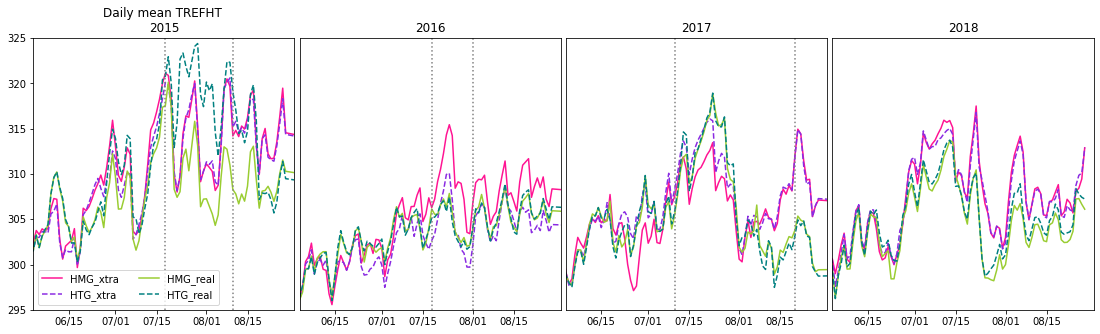

In [145]:
fig,axs = plt.subplots(1,4, figsize=(19,5))
axs     = axs.ravel()
fig.subplots_adjust(wspace=0.02)

axs[0].plot(timeArr, HMGcamDS_localDailyMean_art.TREFHT.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[0].plot(timeArr, HTGcamDS_localDailyMean_art.TREFHT.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(timeArr, HMGcamDS_localDailyMean_real.TREFHT.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[0].plot(timeArr, HTGcamDS_localDailyMean_real.TREFHT.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[0].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,31)])
axs[0].legend(ncol=2)
axs[0].set_title('Daily mean TREFHT \n2015')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(timeArr, HMGcamDS_localDailyMean_art.TREFHT.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[1].plot(timeArr, HTGcamDS_localDailyMean_art.TREFHT.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(timeArr, HMGcamDS_localDailyMean_real.TREFHT.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[1].plot(timeArr, HTGcamDS_localDailyMean_real.TREFHT.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[1].set_xlim([datetime.date(2016,6,3), datetime.date(2016,8,31)])
axs[1].set_title('2016')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[2].plot(timeArr, HMGcamDS_localDailyMean_art.TREFHT.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[2].plot(timeArr, HTGcamDS_localDailyMean_art.TREFHT.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[2].plot(timeArr, HMGcamDS_localDailyMean_real.TREFHT.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[2].plot(timeArr, HTGcamDS_localDailyMean_real.TREFHT.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[2].set_xlim([datetime.date(2017,6,3), datetime.date(2017,8,31)])
axs[2].set_title('2017')
# Format the date into months & days
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[3].plot(timeArr, HMGcamDS_localDailyMean_art.TREFHT.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[3].plot(timeArr, HTGcamDS_localDailyMean_art.TREFHT.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[3].plot(timeArr, HMGcamDS_localDailyMean_real.TREFHT.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[3].plot(timeArr, HTGcamDS_localDailyMean_real.TREFHT.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[3].set_xlim([datetime.date(2018,6,3), datetime.date(2018,8,31)])
axs[3].set_title('2018')
# Format the date into months & days
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].set_ylim([295,325])
axs[1].set_ylim([295,325])
axs[2].set_ylim([295,325])
axs[3].set_ylim([295,325])

axs[1].get_yaxis().set_visible(False)
axs[2].get_yaxis().set_visible(False)
axs[3].get_yaxis().set_visible(False)

## Select some interesting time periods to investigate further
axs[0].axvline(datetime.date(2015,7,18),color='grey',linestyle=':')
axs[0].axvline(datetime.date(2015,8,10),color='grey',linestyle=':')

## Select some interesting time periods to investigate further
axs[1].axvline(datetime.date(2016,7,18),color='grey',linestyle=':')
axs[1].axvline(datetime.date(2016,8,1),color='grey',linestyle=':')

## Select some interesting time periods to investigate further
axs[2].axvline(datetime.date(2017,7,10),color='grey',linestyle=':')
axs[2].axvline(datetime.date(2017,8,20),color='grey',linestyle=':')


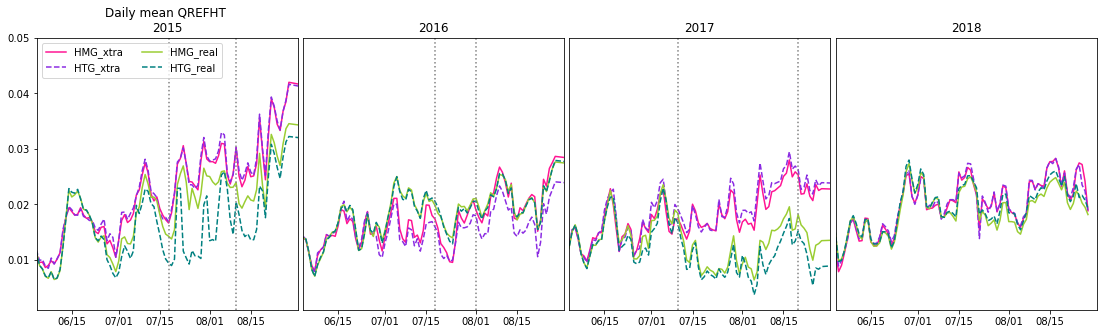

In [146]:
fig,axs = plt.subplots(1,4, figsize=(19,5))
axs     = axs.ravel()
fig.subplots_adjust(wspace=0.02)

axs[0].plot(timeArr, HMGcamDS_localDailyMean_art.QREFHT.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[0].plot(timeArr, HTGcamDS_localDailyMean_art.QREFHT.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(timeArr, HMGcamDS_localDailyMean_real.QREFHT.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[0].plot(timeArr, HTGcamDS_localDailyMean_real.QREFHT.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[0].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,31)])
axs[0].legend(ncol=2)
axs[0].set_title('Daily mean QREFHT \n2015')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(timeArr, HMGcamDS_localDailyMean_art.QREFHT.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[1].plot(timeArr, HTGcamDS_localDailyMean_art.QREFHT.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(timeArr, HMGcamDS_localDailyMean_real.QREFHT.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[1].plot(timeArr, HTGcamDS_localDailyMean_real.QREFHT.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[1].set_xlim([datetime.date(2016,6,3), datetime.date(2016,8,31)])
axs[1].set_title('2016')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[2].plot(timeArr, HMGcamDS_localDailyMean_art.QREFHT.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[2].plot(timeArr, HTGcamDS_localDailyMean_art.QREFHT.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[2].plot(timeArr, HMGcamDS_localDailyMean_real.QREFHT.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[2].plot(timeArr, HTGcamDS_localDailyMean_real.QREFHT.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[2].set_xlim([datetime.date(2017,6,3), datetime.date(2017,8,31)])
axs[2].set_title('2017')
# Format the date into months & days
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[3].plot(timeArr, HMGcamDS_localDailyMean_art.QREFHT.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[3].plot(timeArr, HTGcamDS_localDailyMean_art.QREFHT.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[3].plot(timeArr, HMGcamDS_localDailyMean_real.QREFHT.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[3].plot(timeArr, HTGcamDS_localDailyMean_real.QREFHT.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[3].set_xlim([datetime.date(2018,6,3), datetime.date(2018,8,31)])
axs[3].set_title('2018')
# Format the date into months & days
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].set_ylim([0.001,0.05])
axs[1].set_ylim([0.001,0.05])
axs[2].set_ylim([0.001,0.05])
axs[3].set_ylim([0.001,0.05])

axs[1].get_yaxis().set_visible(False)
axs[2].get_yaxis().set_visible(False)
axs[3].get_yaxis().set_visible(False)

## Select some interesting time periods to investigate further
axs[0].axvline(datetime.date(2015,7,18),color='grey',linestyle=':')
axs[0].axvline(datetime.date(2015,8,10),color='grey',linestyle=':')

## Select some interesting time periods to investigate further
axs[1].axvline(datetime.date(2016,7,18),color='grey',linestyle=':')
axs[1].axvline(datetime.date(2016,8,1),color='grey',linestyle=':')

## Select some interesting time periods to investigate further
axs[2].axvline(datetime.date(2017,7,10),color='grey',linestyle=':')
axs[2].axvline(datetime.date(2017,8,20),color='grey',linestyle=':')


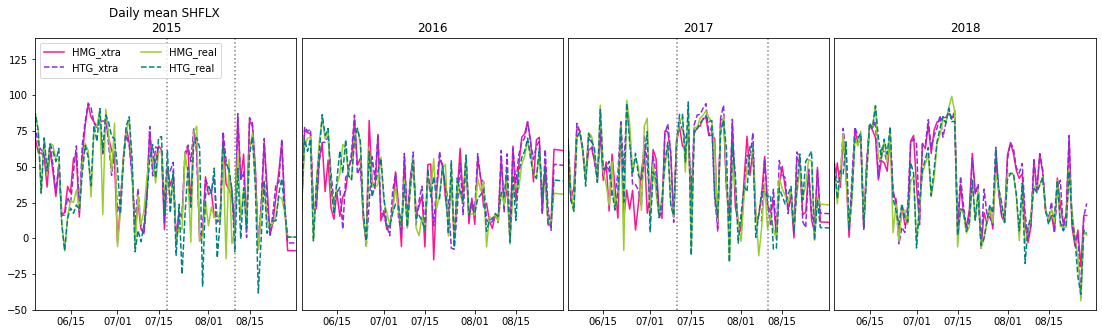

In [131]:
fig,axs = plt.subplots(1,4, figsize=(19,5))
axs     = axs.ravel()
fig.subplots_adjust(wspace=0.02)

axs[0].plot(timeArr, HMGcamDS_localDailyMean_art.SHFLX.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[0].plot(timeArr, HTGcamDS_localDailyMean_art.SHFLX.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(timeArr, HMGcamDS_localDailyMean_real.SHFLX.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[0].plot(timeArr, HTGcamDS_localDailyMean_real.SHFLX.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[0].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,31)])
axs[0].legend(ncol=2)
axs[0].set_title('Daily mean SHFLX \n2015')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(timeArr, HMGcamDS_localDailyMean_art.SHFLX.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[1].plot(timeArr, HTGcamDS_localDailyMean_art.SHFLX.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(timeArr, HMGcamDS_localDailyMean_real.SHFLX.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[1].plot(timeArr, HTGcamDS_localDailyMean_real.SHFLX.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[1].set_xlim([datetime.date(2016,6,3), datetime.date(2016,8,31)])
axs[1].set_title('2016')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[2].plot(timeArr, HMGcamDS_localDailyMean_art.SHFLX.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[2].plot(timeArr, HTGcamDS_localDailyMean_art.SHFLX.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[2].plot(timeArr, HMGcamDS_localDailyMean_real.SHFLX.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[2].plot(timeArr, HTGcamDS_localDailyMean_real.SHFLX.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[2].set_xlim([datetime.date(2017,6,3), datetime.date(2017,8,31)])
axs[2].set_title('2017')
# Format the date into months & days
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[3].plot(timeArr, HMGcamDS_localDailyMean_art.SHFLX.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[3].plot(timeArr, HTGcamDS_localDailyMean_art.SHFLX.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[3].plot(timeArr, HMGcamDS_localDailyMean_real.SHFLX.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[3].plot(timeArr, HTGcamDS_localDailyMean_real.SHFLX.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[3].set_xlim([datetime.date(2018,6,3), datetime.date(2018,8,31)])
axs[3].set_title('2018')
# Format the date into months & days
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].set_ylim([-50,140])
axs[1].set_ylim([-50,140])
axs[2].set_ylim([-50,140])
axs[3].set_ylim([-50,140])

axs[1].get_yaxis().set_visible(False)
axs[2].get_yaxis().set_visible(False)
axs[3].get_yaxis().set_visible(False)

## Select some interesting time periods to investigate further
axs[0].axvline(datetime.date(2015,7,18),color='grey',linestyle=':')
axs[0].axvline(datetime.date(2015,8,10),color='grey',linestyle=':')

## Select some interesting time periods to investigate further
axs[2].axvline(datetime.date(2017,7,10),color='grey',linestyle=':')
axs[2].axvline(datetime.date(2017,8,10),color='grey',linestyle=':')



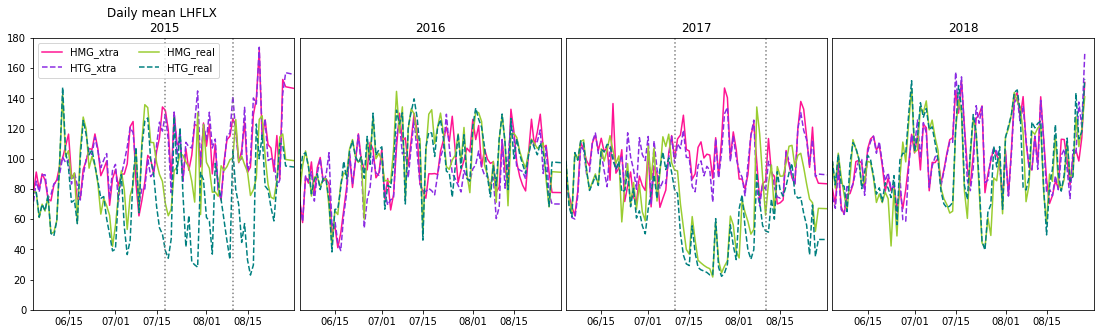

In [135]:
fig,axs = plt.subplots(1,4, figsize=(19,5))
axs     = axs.ravel()
fig.subplots_adjust(wspace=0.02)

axs[0].plot(timeArr, HMGcamDS_localDailyMean_art.LHFLX.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[0].plot(timeArr, HTGcamDS_localDailyMean_art.LHFLX.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(timeArr, HMGcamDS_localDailyMean_real.LHFLX.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[0].plot(timeArr, HTGcamDS_localDailyMean_real.LHFLX.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[0].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,31)])
axs[0].legend(ncol=2)
axs[0].set_title('Daily mean LHFLX \n2015')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(timeArr, HMGcamDS_localDailyMean_art.LHFLX.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[1].plot(timeArr, HTGcamDS_localDailyMean_art.LHFLX.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(timeArr, HMGcamDS_localDailyMean_real.LHFLX.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[1].plot(timeArr, HTGcamDS_localDailyMean_real.LHFLX.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[1].set_xlim([datetime.date(2016,6,3), datetime.date(2016,8,31)])
axs[1].set_title('2016')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[2].plot(timeArr, HMGcamDS_localDailyMean_art.LHFLX.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[2].plot(timeArr, HTGcamDS_localDailyMean_art.LHFLX.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[2].plot(timeArr, HMGcamDS_localDailyMean_real.LHFLX.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[2].plot(timeArr, HTGcamDS_localDailyMean_real.LHFLX.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[2].set_xlim([datetime.date(2017,6,3), datetime.date(2017,8,31)])
axs[2].set_title('2017')
# Format the date into months & days
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[3].plot(timeArr, HMGcamDS_localDailyMean_art.LHFLX.values[:,0,0], color='deeppink',label='HMG_xtra')
axs[3].plot(timeArr, HTGcamDS_localDailyMean_art.LHFLX.values[:,0,0], color='blueviolet',linestyle='--',label='HTG_xtra')
axs[3].plot(timeArr, HMGcamDS_localDailyMean_real.LHFLX.values[:,0,0], color='yellowgreen',label='HMG_real')
axs[3].plot(timeArr, HTGcamDS_localDailyMean_real.LHFLX.values[:,0,0], color='teal',linestyle='--',label='HTG_real')
axs[3].set_xlim([datetime.date(2018,6,3), datetime.date(2018,8,31)])
axs[3].set_title('2018')
# Format the date into months & days
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].set_ylim([0,180])
axs[1].set_ylim([0,180])
axs[2].set_ylim([0,180])
axs[3].set_ylim([0,180])

axs[1].get_yaxis().set_visible(False)
axs[2].get_yaxis().set_visible(False)
axs[3].get_yaxis().set_visible(False)

## Select some interesting time periods to investigate further
axs[0].axvline(datetime.date(2015,7,18),color='grey',linestyle=':')
axs[0].axvline(datetime.date(2015,8,10),color='grey',linestyle=':')

## Select some interesting time periods to investigate further
axs[2].axvline(datetime.date(2017,7,10),color='grey',linestyle=':')
axs[2].axvline(datetime.date(2017,8,10),color='grey',linestyle=':')




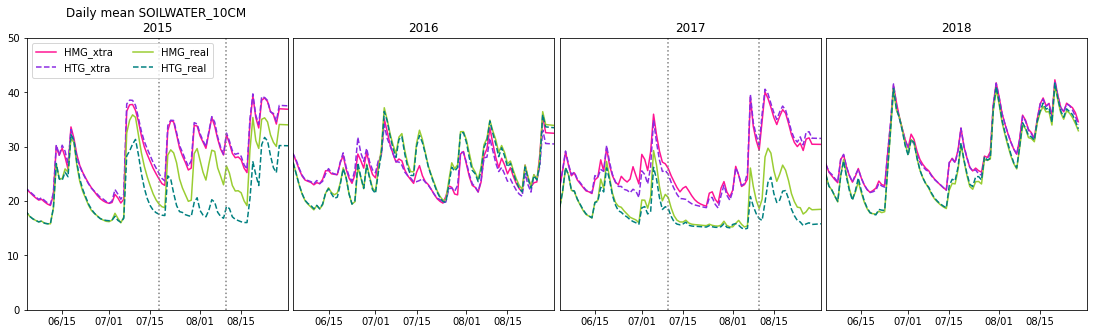

In [273]:
fig,axs = plt.subplots(1,4, figsize=(19,5))
axs     = axs.ravel()
fig.subplots_adjust(wspace=0.02)

axs[0].plot(timeArr, HMGclmDS_localDailyMean_art.SOILWATER_10CM.values, color='deeppink',label='HMG_xtra')
axs[0].plot(timeArr, HTGclmDS_localDailyMean_art.SOILWATER_10CM.values, color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(timeArr, HMGclmDS_localDailyMean_real.SOILWATER_10CM.values, color='yellowgreen',label='HMG_real')
axs[0].plot(timeArr, HTGclmDS_localDailyMean_real.SOILWATER_10CM.values, color='teal',linestyle='--',label='HTG_real')
axs[0].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,31)])
axs[0].legend(ncol=2)
axs[0].set_title('Daily mean SOILWATER_10CM \n2015')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(timeArr, HMGclmDS_localDailyMean_art.SOILWATER_10CM.values, color='deeppink',label='HMG_xtra')
axs[1].plot(timeArr, HTGclmDS_localDailyMean_art.SOILWATER_10CM.values, color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(timeArr, HMGclmDS_localDailyMean_real.SOILWATER_10CM.values, color='yellowgreen',label='HMG_real')
axs[1].plot(timeArr, HTGclmDS_localDailyMean_real.SOILWATER_10CM.values, color='teal',linestyle='--',label='HTG_real')
axs[1].set_xlim([datetime.date(2016,6,3), datetime.date(2016,8,31)])
axs[1].set_title('2016')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[2].plot(timeArr, HMGclmDS_localDailyMean_art.SOILWATER_10CM.values, color='deeppink',label='HMG_xtra')
axs[2].plot(timeArr, HTGclmDS_localDailyMean_art.SOILWATER_10CM.values, color='blueviolet',linestyle='--',label='HTG_xtra')
axs[2].plot(timeArr, HMGclmDS_localDailyMean_real.SOILWATER_10CM.values, color='yellowgreen',label='HMG_real')
axs[2].plot(timeArr, HTGclmDS_localDailyMean_real.SOILWATER_10CM.values, color='teal',linestyle='--',label='HTG_real')
axs[2].set_xlim([datetime.date(2017,6,3), datetime.date(2017,8,31)])
axs[2].set_title('2017')
# Format the date into months & days
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[3].plot(timeArr, HMGclmDS_localDailyMean_art.SOILWATER_10CM.values, color='deeppink',label='HMG_xtra')
axs[3].plot(timeArr, HTGclmDS_localDailyMean_art.SOILWATER_10CM.values, color='blueviolet',linestyle='--',label='HTG_xtra')
axs[3].plot(timeArr, HMGclmDS_localDailyMean_real.SOILWATER_10CM.values, color='yellowgreen',label='HMG_real')
axs[3].plot(timeArr, HTGclmDS_localDailyMean_real.SOILWATER_10CM.values, color='teal',linestyle='--',label='HTG_real')
axs[3].set_xlim([datetime.date(2018,6,3), datetime.date(2018,8,31)])
axs[3].set_title('2018')
# Format the date into months & days
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].set_ylim([0,50])
axs[1].set_ylim([0,50])
axs[2].set_ylim([0,50])
axs[3].set_ylim([0,50])

axs[1].get_yaxis().set_visible(False)
axs[2].get_yaxis().set_visible(False)
axs[3].get_yaxis().set_visible(False)

## Select some interesting time periods to investigate further
axs[0].axvline(datetime.date(2015,7,18),color='grey',linestyle=':')
axs[0].axvline(datetime.date(2015,8,10),color='grey',linestyle=':')

## Select some interesting time periods to investigate further
axs[2].axvline(datetime.date(2017,7,10),color='grey',linestyle=':')
axs[2].axvline(datetime.date(2017,8,10),color='grey',linestyle=':')




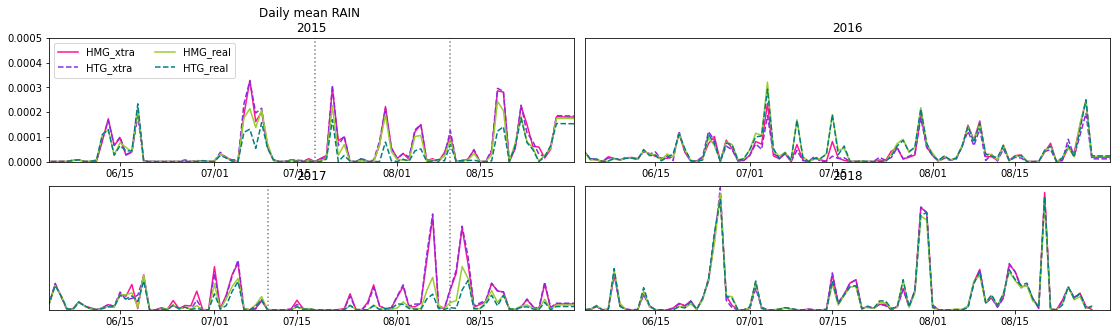

In [277]:
fig,axs = plt.subplots(2,2, figsize=(19,5))
axs     = axs.ravel()
fig.subplots_adjust(wspace=0.02)

axs[0].plot(timeArr, HMGclmDS_localDailyMean_art.RAIN.values, color='deeppink',label='HMG_xtra')
axs[0].plot(timeArr, HTGclmDS_localDailyMean_art.RAIN.values, color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(timeArr, HMGclmDS_localDailyMean_real.RAIN.values, color='yellowgreen',label='HMG_real')
axs[0].plot(timeArr, HTGclmDS_localDailyMean_real.RAIN.values, color='teal',linestyle='--',label='HTG_real')
axs[0].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,31)])
axs[0].legend(ncol=2)
axs[0].set_title('Daily mean RAIN \n2015')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(timeArr, HMGclmDS_localDailyMean_art.RAIN.values, color='deeppink',label='HMG_xtra')
axs[1].plot(timeArr, HTGclmDS_localDailyMean_art.RAIN.values, color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(timeArr, HMGclmDS_localDailyMean_real.RAIN.values, color='yellowgreen',label='HMG_real')
axs[1].plot(timeArr, HTGclmDS_localDailyMean_real.RAIN.values, color='teal',linestyle='--',label='HTG_real')
axs[1].set_xlim([datetime.date(2016,6,3), datetime.date(2016,8,31)])
axs[1].set_title('2016')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[2].plot(timeArr, HMGclmDS_localDailyMean_art.RAIN.values, color='deeppink',label='HMG_xtra')
axs[2].plot(timeArr, HTGclmDS_localDailyMean_art.RAIN.values, color='blueviolet',linestyle='--',label='HTG_xtra')
axs[2].plot(timeArr, HMGclmDS_localDailyMean_real.RAIN.values, color='yellowgreen',label='HMG_real')
axs[2].plot(timeArr, HTGclmDS_localDailyMean_real.RAIN.values, color='teal',linestyle='--',label='HTG_real')
axs[2].set_xlim([datetime.date(2017,6,3), datetime.date(2017,8,31)])
axs[2].set_title('2017')
# Format the date into months & days
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[3].plot(timeArr, HMGclmDS_localDailyMean_art.RAIN.values, color='deeppink',label='HMG_xtra')
axs[3].plot(timeArr, HTGclmDS_localDailyMean_art.RAIN.values, color='blueviolet',linestyle='--',label='HTG_xtra')
axs[3].plot(timeArr, HMGclmDS_localDailyMean_real.RAIN.values, color='yellowgreen',label='HMG_real')
axs[3].plot(timeArr, HTGclmDS_localDailyMean_real.RAIN.values, color='teal',linestyle='--',label='HTG_real')
axs[3].set_xlim([datetime.date(2018,6,3), datetime.date(2018,8,31)])
axs[3].set_title('2018')
# Format the date into months & days
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].set_ylim([0,0.0005])
axs[1].set_ylim([0,0.0005])
axs[2].set_ylim([0,0.0005])
axs[3].set_ylim([0,0.0005])

axs[1].get_yaxis().set_visible(False)
axs[2].get_yaxis().set_visible(False)
axs[3].get_yaxis().set_visible(False)

## Select some interesting time periods to investigate further
axs[0].axvline(datetime.date(2015,7,18),color='grey',linestyle=':')
axs[0].axvline(datetime.date(2015,8,10),color='grey',linestyle=':')

## Select some interesting time periods to investigate further
axs[2].axvline(datetime.date(2017,7,10),color='grey',linestyle=':')
axs[2].axvline(datetime.date(2017,8,10),color='grey',linestyle=':')





## What are some ways we can separate data?

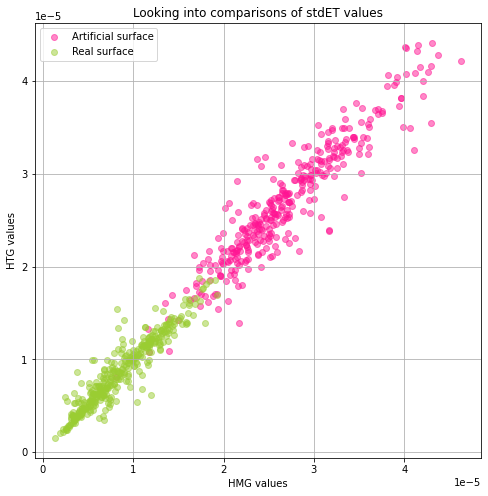

In [45]:
## Visualize some of the daily mean values 
fig,axs = plt.subplots(1,1, figsize=(8,8))

axs.scatter(HMGclmDS_localDailyMean_art.stdET.values, HTGclmDS_localDailyMean_art.stdET.values,
            color='deeppink', alpha=0.5)
axs.scatter(HMGclmDS_localDailyMean_real.stdET.values, HTGclmDS_localDailyMean_real.stdET.values,
            color='yellowgreen', alpha=0.5)

axs.set_title('Looking into comparisons of stdET values')
axs.set_xlabel('HMG values')
axs.set_ylabel('HTG values')
axs.legend(['Artificial surface', 'Real surface'])
axs.grid()

(-1.0, 5.0)

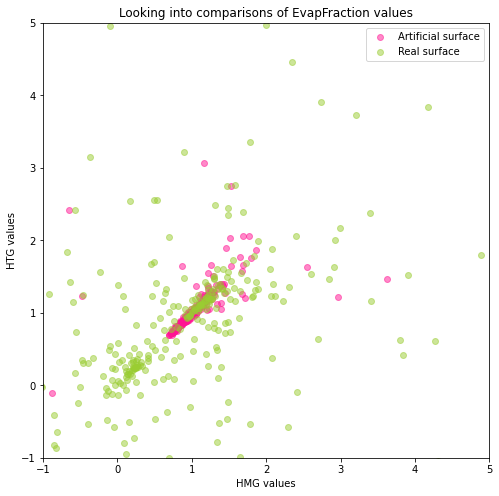

In [79]:
## Visualize some of the daily mean values 
fig,axs = plt.subplots(1,1, figsize=(8,8))

axs.scatter(HMGcamDS_localDailyMean_art.EvapFraction.values, HTGcamDS_localDailyMean_art.EvapFraction.values,
            color='deeppink', alpha=0.5)
axs.scatter(HMGcamDS_localDailyMean_real.EvapFraction.values, HTGcamDS_localDailyMean_real.EvapFraction.values,
            color='yellowgreen', alpha=0.5)

axs.set_title('Looking into comparisons of EvapFraction values')
axs.set_xlabel('HMG values')
axs.set_ylabel('HTG values')
axs.legend(['Artificial surface', 'Real surface'])

axs.set_ylim([-1,5])
axs.set_xlim([-1,5])

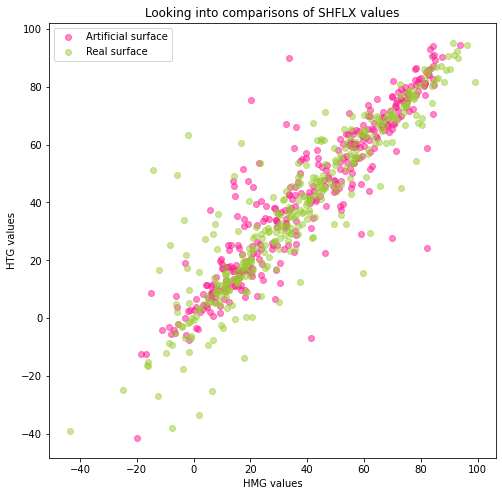

In [24]:
## Visualize some of the daily mean values 
fig,axs = plt.subplots(1,1, figsize=(8,8))

axs.scatter(HMGcamDS_localDailyMean_art.SHFLX.values, HTGcamDS_localDailyMean_art.SHFLX.values,
            color='deeppink', alpha=0.5)
axs.scatter(HMGcamDS_localDailyMean_real.SHFLX.values, HTGcamDS_localDailyMean_real.SHFLX.values,
            color='yellowgreen', alpha=0.5)

axs.set_title('Looking into comparisons of SHFLX values')
axs.set_xlabel('HMG values')
axs.set_ylabel('HTG values')
axs.legend(['Artificial surface', 'Real surface'])



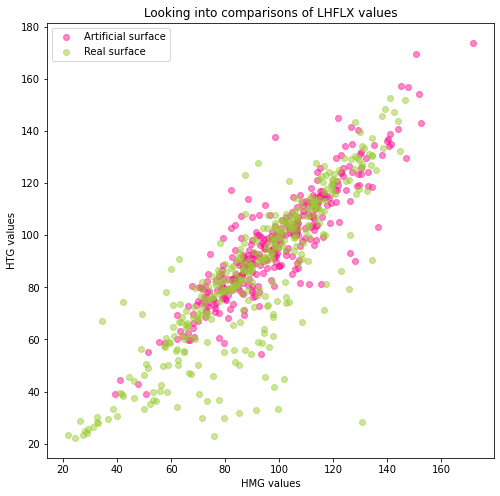

In [72]:
## Visualize some of the daily mean values 
fig,axs = plt.subplots(1,1, figsize=(8,8))

axs.scatter(HMGcamDS_localDailyMean_art.LHFLX.values, HTGcamDS_localDailyMean_art.LHFLX.values,
            color='deeppink', alpha=0.5)
axs.scatter(HMGcamDS_localDailyMean_real.LHFLX.values, HTGcamDS_localDailyMean_real.LHFLX.values,
            color='yellowgreen', alpha=0.5)

axs.set_title('Looking into comparisons of LHFLX values')
axs.set_xlabel('HMG values')
axs.set_ylabel('HTG values')
axs.legend(['Artificial surface', 'Real surface'])




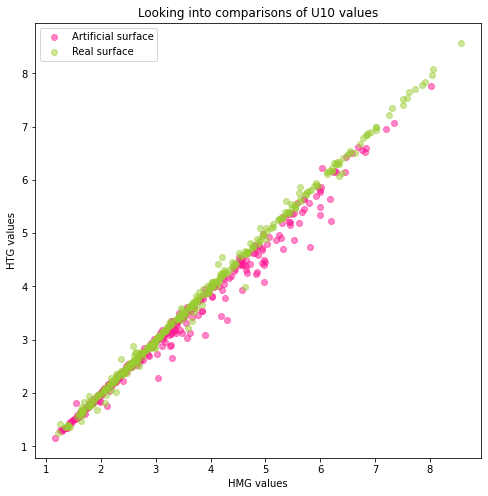

In [25]:
## Visualize some of the daily mean values 
fig,axs = plt.subplots(1,1, figsize=(8,8))

axs.scatter(HMGcamDS_localDailyMean_art.U10.values, HTGcamDS_localDailyMean_art.U10.values,
            color='deeppink', alpha=0.5)
axs.scatter(HMGcamDS_localDailyMean_real.U10.values, HTGcamDS_localDailyMean_real.U10.values,
            color='yellowgreen', alpha=0.5)

axs.set_title('Looking into comparisons of U10 values')
axs.set_xlabel('HMG values')
axs.set_ylabel('HTG values')
axs.legend(['Artificial surface', 'Real surface'])




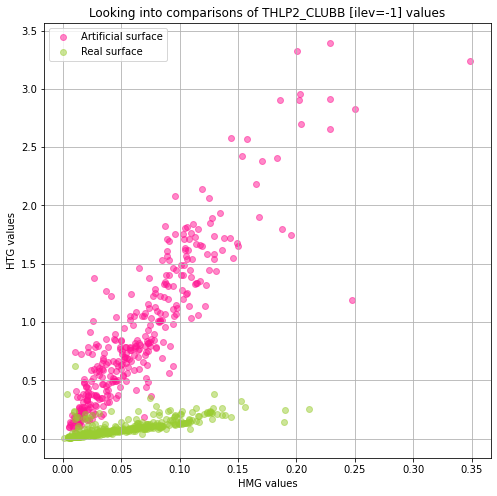

In [15]:
## Visualize some of the daily mean values 
fig,axs = plt.subplots(1,1, figsize=(8,8))

controlVar = 'THLP2_CLUBB'

axs.scatter(HMGcamDS_localDailyMean_art[controlVar].values[:,-1,0,0], HTGcamDS_localDailyMean_art[controlVar].values[:,-1,0,0],
            color='deeppink', alpha=0.5)
axs.scatter(HMGcamDS_localDailyMean_real[controlVar].values[:,-1,0,0], HTGcamDS_localDailyMean_real[controlVar].values[:,-1,0,0],
            color='yellowgreen', alpha=0.5)

axs.set_title('Looking into comparisons of '+controlVar+' [ilev=-1] values')
axs.set_xlabel('HMG values')
axs.set_ylabel('HTG values')
axs.legend(['Artificial surface', 'Real surface'])

axs.grid()


(0.0, 3.0)

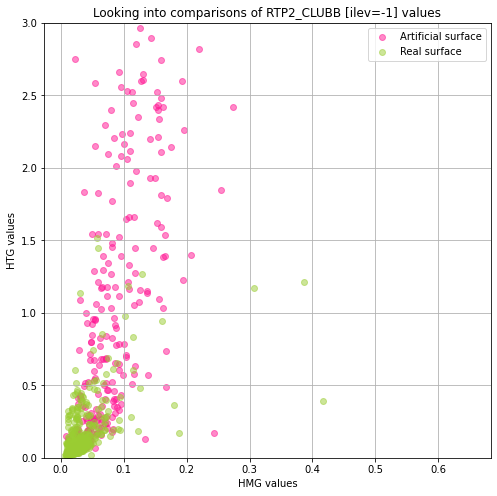

In [36]:
## Visualize some of the daily mean values 
fig,axs = plt.subplots(1,1, figsize=(8,8))

controlVar = 'RTP2_CLUBB'

axs.scatter(HMGcamDS_localDailyMean_art[controlVar].values[:,-1,0,0], HTGcamDS_localDailyMean_art[controlVar].values[:,-1,0,0],
            color='deeppink', alpha=0.5)
axs.scatter(HMGcamDS_localDailyMean_real[controlVar].values[:,-1,0,0], HTGcamDS_localDailyMean_real[controlVar].values[:,-1,0,0],
            color='yellowgreen', alpha=0.5)

axs.set_title('Looking into comparisons of '+controlVar+' [ilev=-1] values')
axs.set_xlabel('HMG values')
axs.set_ylabel('HTG values')
axs.legend(['Artificial surface', 'Real surface'])

axs.grid()

axs.set_ylim([0,3])
# axs.set_xlim([0,0.3])

(-1.0, 0.5)

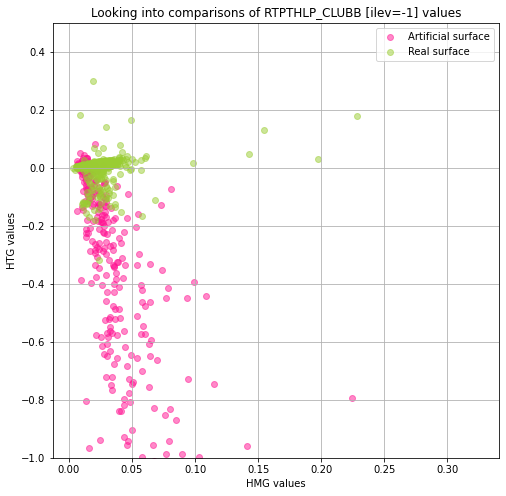

In [41]:
## Visualize some of the daily mean values 
fig,axs = plt.subplots(1,1, figsize=(8,8))

controlVar = 'RTPTHLP_CLUBB'

axs.scatter(HMGcamDS_localDailyMean_art[controlVar].values[:,-1,0,0], HTGcamDS_localDailyMean_art[controlVar].values[:,-1,0,0],
            color='deeppink', alpha=0.5)
axs.scatter(HMGcamDS_localDailyMean_real[controlVar].values[:,-1,0,0], HTGcamDS_localDailyMean_real[controlVar].values[:,-1,0,0],
            color='yellowgreen', alpha=0.5)

axs.set_title('Looking into comparisons of '+controlVar+' [ilev=-1] values')
axs.set_xlabel('HMG values')
axs.set_ylabel('HTG values')
axs.legend(['Artificial surface', 'Real surface'])

axs.grid()

axs.set_ylim([-1,0.5])
# axs.set_xlim([0,0.3])

### Try looking at just values with "low" moments in HTG (at least wrt artificial surface values

In [27]:
'''
Find all the times in the full array (dt) that match up with daily mean conditions 
'''
def getTimes_basedOnCondition(fullDS, conditionDS):
    iTimes = []
    
    for iTime in range(len(conditionDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==conditionDS.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==conditionDS.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==conditionDS.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_match = fullDS.isel(time=iTimes)
    
    return(DS_match)



In [62]:
## Also going to add selection for month - for june, before systematic changes have set up - is the response similar? 
selMonth = 6


## If variable is 3D and within CAM output: 

selVar   = 'THLP2_CLUBB'
selLev   = -1
iMax_val = 0.5
iMin_val = 0

## Now find where those conditions are met in each array 
#  But right now, I'm interested in just the HTG values, so don't need to seperately select HMG days 
iselDays_HMGart  = np.where( (HMGcamDS_localDailyMean_art[selVar].values[:,selLev,0,0]>=iMin_val) 
                           & (HMGcamDS_localDailyMean_art[selVar].values[:,selLev,0,0]<=iMax_val)
                           & (HMGcamDS_localDailyMean_art.year_month_day_level_1.values==selMonth))[0]

iselDays_HTGart  = np.where( (HTGcamDS_localDailyMean_art[selVar].values[:,selLev,0,0]>=iMin_val) 
                           & (HTGcamDS_localDailyMean_art[selVar].values[:,selLev,0,0]<=iMax_val)
                           & (HTGcamDS_localDailyMean_art.year_month_day_level_1.values==selMonth))[0]


iselDays_HMGreal = np.where( (HMGcamDS_localDailyMean_real[selVar].values[:,selLev,0,0]>=iMin_val) 
                           & (HMGcamDS_localDailyMean_real[selVar].values[:,selLev,0,0]<=iMax_val)
                           & (HMGcamDS_localDailyMean_real.year_month_day_level_1.values==selMonth))[0]

iselDays_HTGreal = np.where( (HTGcamDS_localDailyMean_real[selVar].values[:,selLev,0,0]>=iMin_val) 
                           & (HTGcamDS_localDailyMean_real[selVar].values[:,selLev,0,0]<=iMax_val)
                           & (HTGcamDS_localDailyMean_real.year_month_day_level_1.values==selMonth))[0]


## If variable is 2D and within CLM output: 

# selVar   = 'stdET'
# iMax_val = 2.25e-5
# iMin_val = 1.25e-5 

# ## Now find where those conditions are met in each array 
# #  But right now, I'm interested in just the HTG values, so don't need to seperately select HMG days 
# iselDays_HMGart  = np.where( (HMGclmDS_localDailyMean_art[selVar].values>=iMin_val) 
#                            & (HMGclmDS_localDailyMean_art[selVar].values<=iMax_val) 
#                            & (HMGclmDS_localDailyMean_art.year_month_day_level_1.values==selMonth))[0]

# iselDays_HTGart  = np.where( (HTGclmDS_localDailyMean_art[selVar].values>=iMin_val) 
#                            & (HTGclmDS_localDailyMean_art[selVar].values<=iMax_val)
#                            & (HMGclmDS_localDailyMean_art.year_month_day_level_1.values==selMonth))[0]


# iselDays_HMGreal = np.where( (HMGclmDS_localDailyMean_real[selVar].values>=iMin_val) 
#                            & (HMGclmDS_localDailyMean_real[selVar].values<=iMax_val)
#                            & (HMGclmDS_localDailyMean_art.year_month_day_level_1.values==selMonth))[0]

# iselDays_HTGreal = np.where( (HTGclmDS_localDailyMean_real[selVar].values>=iMin_val) 
#                            & (HTGclmDS_localDailyMean_real[selVar].values<=iMax_val)
#                            & (HMGclmDS_localDailyMean_art.year_month_day_level_1.values==selMonth))[0]



## Only keep days where both HMG *and* HTG cases meet the condition 
setHMG_art = set(iselDays_HMGart)
setHTG_art = set(iselDays_HTGart)
iKeep_art  = list(setHMG_art & setHTG_art)
HMG_art   = HMGcamDS_localDailyMean_art.isel(year_month_day = iKeep_art)
HTG_art   = HTGcamDS_localDailyMean_art.isel(year_month_day = iKeep_art)

setHMG_real = set(iselDays_HMGreal)
setHTG_real = set(iselDays_HTGreal)
iKeep_real  = list(setHMG_real & setHTG_real)
HMG_real   = HMGcamDS_localDailyMean_art.isel(year_month_day = iKeep_real)
HTG_real   = HTGcamDS_localDailyMean_art.isel(year_month_day = iKeep_real)


print('Number of days meeting condition in artificial case: ', len(iKeep_art))
print('Number of days meeting condition in real case:       ', len(iKeep_real))

HMGcamDS_art_condition = getTimes_basedOnCondition(HMGcamDS_artificial, HMG_art)
HTGcamDS_art_condition = getTimes_basedOnCondition(HTGcamDS_artificial, HTG_art)

HMGcamDS_real_condition = getTimes_basedOnCondition(HMGcamDS_real, HMG_real)
HTGcamDS_real_condition = getTimes_basedOnCondition(HTGcamDS_real, HTG_real)



Number of days meeting condition in artificial case:  37
Number of days meeting condition in real case:        116


In [63]:

# Get means a function of hour of day within each dry/wet day category
hourlyMean_artificial_HMG = HMGcamDS_art_condition.groupby("time.hour").mean()
hourlyMean_artificial_HTG = HTGcamDS_art_condition.groupby("time.hour").mean()

hourlyMean_real_HMG = HMGcamDS_real_condition.groupby("time.hour").mean()
hourlyMean_real_HTG = HTGcamDS_real_condition.groupby("time.hour").mean()

# Get std as function of hour of day too
hourlyStd_artificial_HMG = HMGcamDS_art_condition.groupby("time.hour").std(dim='time')
hourlyStd_artificial_HTG = HTGcamDS_art_condition.groupby("time.hour").std(dim='time')

hourlyStd_real_HMG = HMGcamDS_real_condition.groupby("time.hour").std(dim='time')
hourlyStd_real_HTG = HTGcamDS_real_condition.groupby("time.hour").std(dim='time')


# Get number of obs going into those hourly means (for error bars)
nTimes_artificial = np.full([24], np.nan)
nTimes_real       = np.full([24], np.nan)

for iHr in range(24): 
    nTimes_artificial[iHr] = len(np.where(HMGcamDS_art_condition["time.hour"]==iHr)[0])
    nTimes_real[iHr]       = len(np.where(HMGcamDS_real_condition["time.hour"]==iHr)[0])

    
hourlyMean_artificial_HMG['SampleCount']         = (('hour'), nTimes_artificial)
hourlyMean_artificial_HTG['SampleCount']         = (('hour'), nTimes_artificial)

hourlyMean_real_HMG['SampleCount']         = (('hour'), nTimes_real)
hourlyMean_real_HTG['SampleCount']         = (('hour'), nTimes_real)



/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

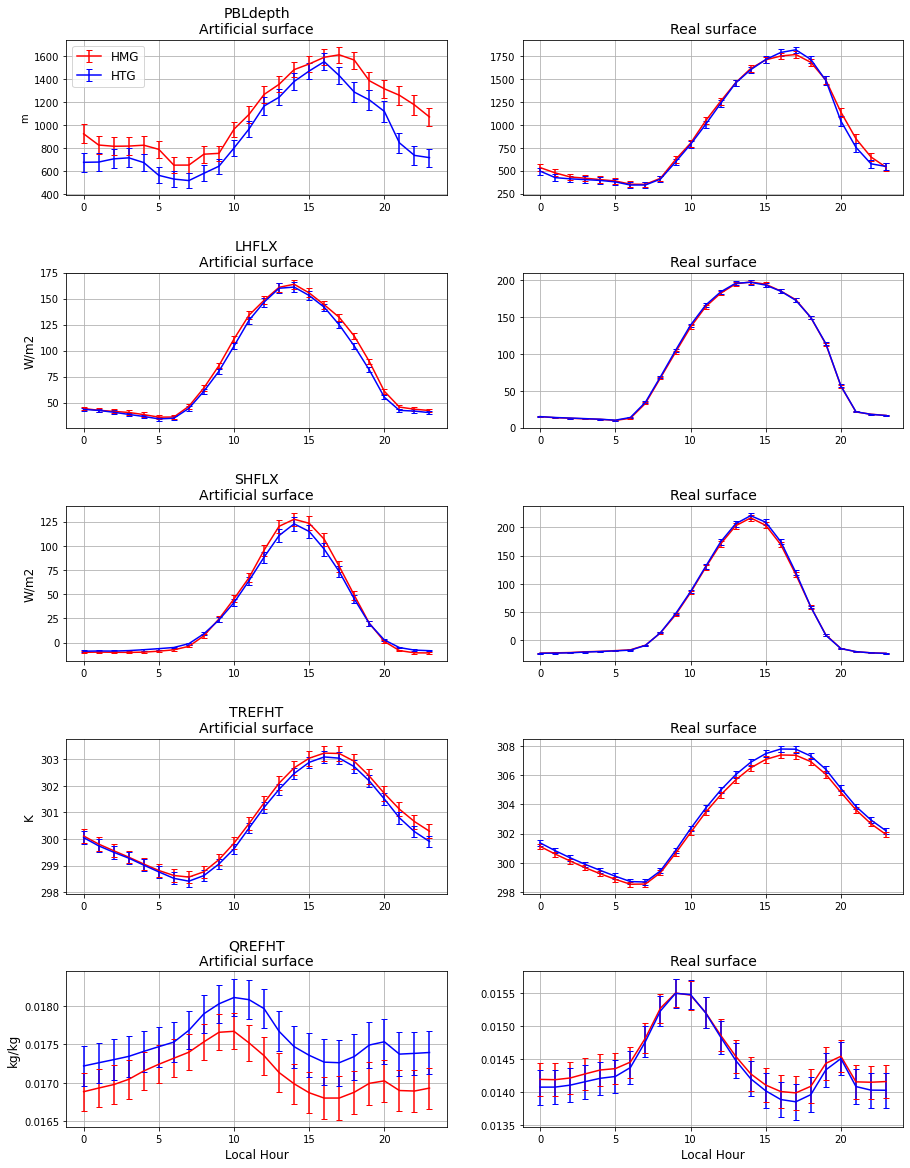

In [64]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
varSel = np.asarray(['PBLdepth','LHFLX','SHFLX','TREFHT','QREFHT'])

fig,axs = plt.subplots(len(varSel),2, figsize=(15,20))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([2300])
yMin = np.asarray([ 100])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_artificial_HMG.hour.values, np.squeeze(hourlyMean_artificial_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_artificial_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_artificial_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_artificial_HTG.hour.values, np.squeeze(hourlyMean_artificial_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_artificial_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_artificial_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(varSel[iVar]+'\nArtificial surface', fontsize=14)
    if varSel[iVar]=='PBLdepth':
#         axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
        axs[iPlot].set_ylabel('m')
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_real[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_real_HMG.hour.values, np.squeeze(hourlyMean_real_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_real_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_real_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_real_HTG.hour.values, np.squeeze(hourlyMean_real_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_real_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_real_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nReal surface', fontsize=14)  
    
#     axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
#     axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
    axs[iPlot+0].grid()
    axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2

    

### What if we only look at when all the moments of HTG are within the range simulated by the 'real' sfc case?

In [69]:
mxHTG_thlp2 = np.nanmax(HTGcamDS_localDailyMean_real.THLP2_CLUBB.values[:,-1,0,0])
mxHTG_rtp2  = np.nanmax(HTGcamDS_localDailyMean_real.RTP2_CLUBB.values[:,-1,0,0])
mxHTG_rtpthlp = np.nanmax(HTGcamDS_localDailyMean_real.RTPTHLP_CLUBB.values[:,-1,0,0])

mnHTG_thlp2 = np.nanmin(HTGcamDS_localDailyMean_real.THLP2_CLUBB.values[:,-1,0,0])
mnHTG_rtp2  = np.nanmin(HTGcamDS_localDailyMean_real.RTP2_CLUBB.values[:,-1,0,0])
mnHTG_rtpthlp = np.nanmin(HTGcamDS_localDailyMean_real.RTPTHLP_CLUBB.values[:,-1,0,0])

match_artificialHTG = np.where( (HTGcamDS_localDailyMean_art.THLP2_CLUBB.values[:,-1,0,0] >=mnHTG_thlp2) 
                              & (HTGcamDS_localDailyMean_art.THLP2_CLUBB.values[:,-1,0,0] <=mxHTG_thlp2)
                              & (HTGcamDS_localDailyMean_art.RTP2_CLUBB.values[:,-1,0,0] >=mnHTG_rtp2) 
                              & (HTGcamDS_localDailyMean_art.RTP2_CLUBB.values[:,-1,0,0] <=mxHTG_rtp2)
                              & (HTGcamDS_localDailyMean_art.RTPTHLP_CLUBB.values[:,-1,0,0] >=mnHTG_rtpthlp) 
                              & (HTGcamDS_localDailyMean_art.RTPTHLP_CLUBB.values[:,-1,0,0] <=mxHTG_rtpthlp))[0]

HMG_art   = HMGcamDS_localDailyMean_art.isel(year_month_day = match_artificialHTG)
HTG_art   = HTGcamDS_localDailyMean_art.isel(year_month_day = match_artificialHTG)

HMGcamDS_art_condition = getTimes_basedOnCondition(HMGcamDS_artificial, HMG_art)
HTGcamDS_art_condition = getTimes_basedOnCondition(HTGcamDS_artificial, HTG_art)


In [70]:

# Get means a function of hour of day within each dry/wet day category
hourlyMean_artificial_HMG = HMGcamDS_art_condition.groupby("time.hour").mean()
hourlyMean_artificial_HTG = HTGcamDS_art_condition.groupby("time.hour").mean()

hourlyMean_real_HMG = HMGcamDS_real.groupby("time.hour").mean()
hourlyMean_real_HTG = HTGcamDS_real.groupby("time.hour").mean()

# Get std as function of hour of day too
hourlyStd_artificial_HMG = HMGcamDS_art_condition.groupby("time.hour").std(dim='time')
hourlyStd_artificial_HTG = HTGcamDS_art_condition.groupby("time.hour").std(dim='time')

hourlyStd_real_HMG = HMGcamDS_real.groupby("time.hour").std(dim='time')
hourlyStd_real_HTG = HTGcamDS_real.groupby("time.hour").std(dim='time')


# Get number of obs going into those hourly means (for error bars)
nTimes_artificial = np.full([24], np.nan)
nTimes_real       = np.full([24], np.nan)

for iHr in range(24): 
    nTimes_artificial[iHr] = len(np.where(HMGcamDS_art_condition["time.hour"]==iHr)[0])
    nTimes_real[iHr]       = len(np.where(HMGcamDS_real["time.hour"]==iHr)[0])

    
hourlyMean_artificial_HMG['SampleCount']         = (('hour'), nTimes_artificial)
hourlyMean_artificial_HTG['SampleCount']         = (('hour'), nTimes_artificial)

hourlyMean_real_HMG['SampleCount']         = (('hour'), nTimes_real)
hourlyMean_real_HTG['SampleCount']         = (('hour'), nTimes_real)




/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mdfowler/opt/anaconda3/

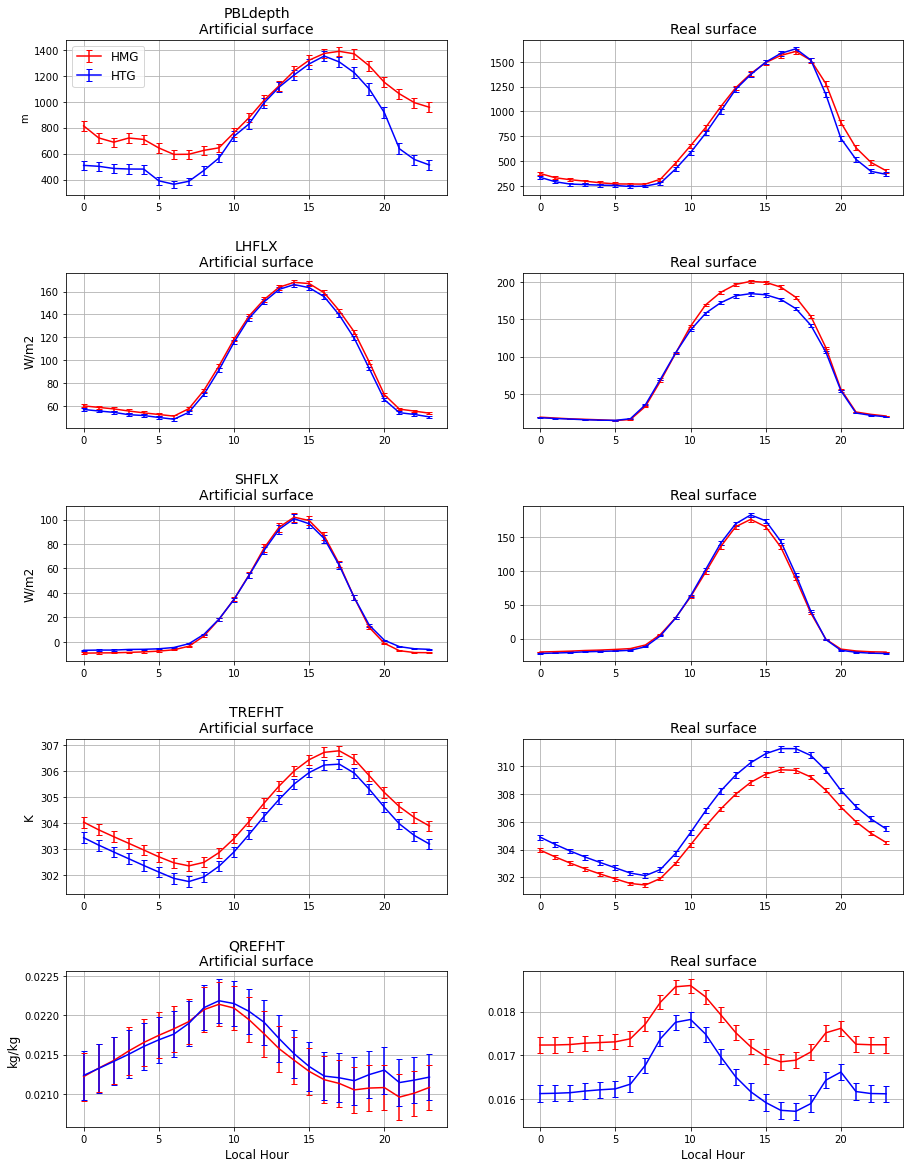

In [71]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
varSel = np.asarray(['PBLdepth','LHFLX','SHFLX','TREFHT','QREFHT'])

fig,axs = plt.subplots(len(varSel),2, figsize=(15,20))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([2300])
yMin = np.asarray([ 100])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_artificial_HMG.hour.values, np.squeeze(hourlyMean_artificial_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_artificial_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_artificial_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_artificial_HTG.hour.values, np.squeeze(hourlyMean_artificial_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_artificial_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_artificial_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(varSel[iVar]+'\nArtificial surface', fontsize=14)
    if varSel[iVar]=='PBLdepth':
#         axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
        axs[iPlot].set_ylabel('m')
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_real[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_real_HMG.hour.values, np.squeeze(hourlyMean_real_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_real_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_real_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_real_HTG.hour.values, np.squeeze(hourlyMean_real_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_real_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_real_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nReal surface', fontsize=14)  
    
#     axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
#     axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
    axs[iPlot+0].grid()
    axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2


## Let's zoom into some of the interesting 'windows' identified in the first section 

In [143]:
## Read in forcing too...
nateForcingFileHTG = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-htg.nc'
nateDS             = xr.open_dataset(nateForcingFileHTG, decode_times='True')


In [215]:
iWindow1 = np.where( (HMGcamDS_artificial.time.values>=np.datetime64('2015-07-08'))
                   & (HMGcamDS_artificial.time.values<=np.datetime64('2015-08-11')))[0]

iWindow2 = np.where( (HMGcamDS_artificial.time.values>=np.datetime64('2016-07-18'))
                   & (HMGcamDS_artificial.time.values<=np.datetime64('2016-08-02')))[0]

iWindow3 = np.where( (HMGcamDS_artificial.time.values>=np.datetime64('2017-07-10'))
                   & (HMGcamDS_artificial.time.values<=np.datetime64('2017-08-21')))[0]


window1_HMGartitificial = HMGcamDS_artificial.isel(time=iWindow1)
window1_HTGartitificial = HTGcamDS_artificial.isel(time=iWindow1)
window1_HMGreal = HMGcamDS_real.isel(time=iWindow1)
window1_HTGreal = HTGcamDS_real.isel(time=iWindow1)


window2_HMGartitificial = HMGcamDS_artificial.isel(time=iWindow2)
window2_HTGartitificial = HTGcamDS_artificial.isel(time=iWindow2)
window2_HMGreal = HMGcamDS_real.isel(time=iWindow2)
window2_HTGreal = HTGcamDS_real.isel(time=iWindow2)


window3_HMGartitificial = HMGcamDS_artificial.isel(time=iWindow3)
window3_HTGartitificial = HTGcamDS_artificial.isel(time=iWindow3)
window3_HMGreal = HMGcamDS_real.isel(time=iWindow3)
window3_HTGreal = HTGcamDS_real.isel(time=iWindow3)


In [216]:
## Land datasets too 
window1_HMGartitificialCLM = HMGclmDS_artificial.isel(time=iWindow1)
window1_HTGartitificialCLM = HTGclmDS_artificial.isel(time=iWindow1)
window1_HMGrealCLM = HMGclmDS_real.isel(time=iWindow1)
window1_HTGrealCLM = HTGclmDS_real.isel(time=iWindow1)


window2_HMGartitificialCLM = HMGclmDS_artificial.isel(time=iWindow2)
window2_HTGartitificialCLM = HTGclmDS_artificial.isel(time=iWindow2)
window2_HMGrealCLM = HMGclmDS_real.isel(time=iWindow2)
window2_HTGrealCLM = HTGclmDS_real.isel(time=iWindow2)

window3_HMGartitificialCLM = HMGclmDS_artificial.isel(time=iWindow3)
window3_HTGartitificialCLM = HTGclmDS_artificial.isel(time=iWindow3)
window3_HMGrealCLM = HMGclmDS_real.isel(time=iWindow3)
window3_HTGrealCLM = HTGclmDS_real.isel(time=iWindow3)


In [152]:
## Get those windows in the forcings too
iWindow1obs = np.where( (nateDS.time.values>=np.datetime64('2015-07-08'))
                   & (nateDS.time.values<=np.datetime64('2015-08-11')))[0]

iWindow2obs = np.where( (nateDS.time.values>=np.datetime64('2016-07-18'))
                   & (nateDS.time.values<=np.datetime64('2016-08-02')))[0]

iWindow3obs = np.where( (nateDS.time.values>=np.datetime64('2017-07-10'))
                   & (nateDS.time.values<=np.datetime64('2017-08-21')))[0]

window1_nateDS = nateDS.isel(time=iWindow1obs)
window2_nateDS = nateDS.isel(time=iWindow2obs)
window3_nateDS = nateDS.isel(time=iWindow3obs)


**Window 1: 2015**

(16634.0, 16648.0)

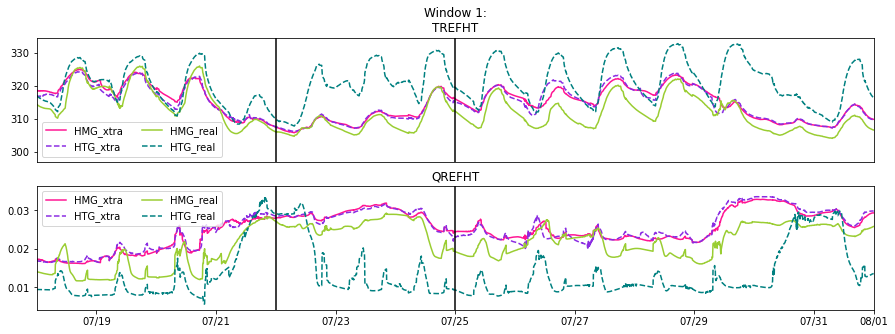

In [218]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.TREFHT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.TREFHT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window1_HMGreal.time.values, window1_HMGreal.TREFHT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window1_HTGreal.time.values, window1_HTGreal.TREFHT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 1:\nTREFHT')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.QREFHT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.QREFHT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window1_HMGreal.time.values, window1_HMGreal.QREFHT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window1_HTGreal.time.values, window1_HTGreal.QREFHT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2)
axs[1].set_title('QREFHT')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)


axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])


(16634.0, 16648.0)

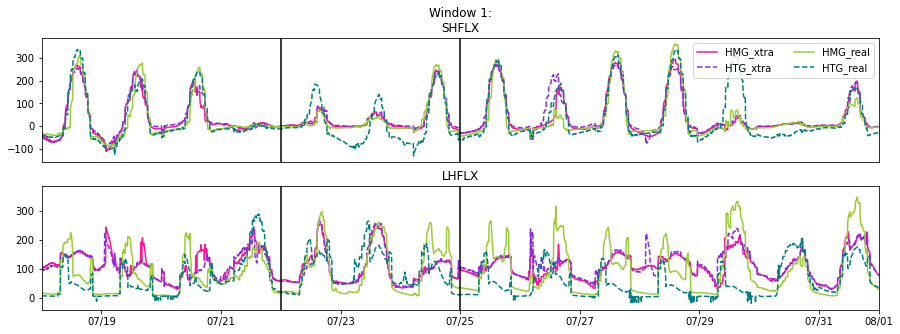

In [219]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.SHFLX.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.SHFLX.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window1_HMGreal.time.values, window1_HMGreal.SHFLX.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window1_HTGreal.time.values, window1_HTGreal.SHFLX.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 1:\nSHFLX')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.LHFLX.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.LHFLX.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window1_HMGreal.time.values, window1_HMGreal.LHFLX.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window1_HTGreal.time.values, window1_HTGreal.LHFLX.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('LHFLX')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)


axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])


(16634.0, 16648.0)

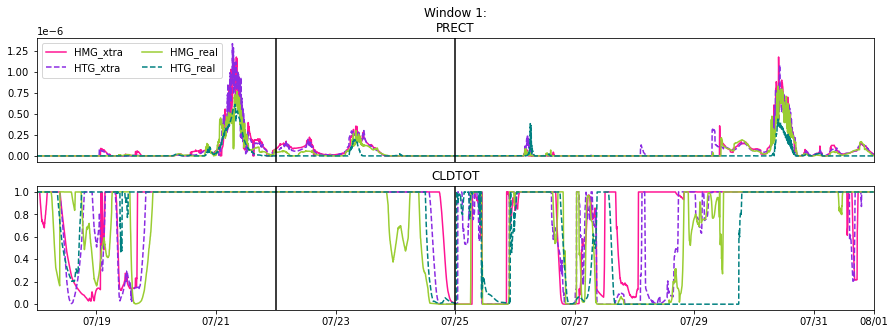

In [220]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.PRECT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.PRECT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window1_HMGreal.time.values, window1_HMGreal.PRECT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window1_HTGreal.time.values, window1_HTGreal.PRECT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 1:\nPRECT')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.CLDTOT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.CLDTOT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window1_HMGreal.time.values, window1_HMGreal.CLDTOT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window1_HTGreal.time.values, window1_HTGreal.CLDTOT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('CLDTOT')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)


axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])


(16634.0, 16648.0)

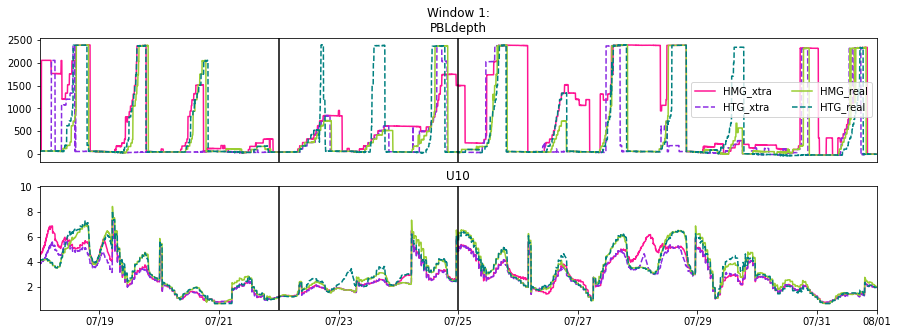

In [233]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.PBLdepth.values, 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.PBLdepth.values, 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window1_HMGreal.time.values, window1_HMGreal.PBLdepth.values, 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window1_HTGreal.time.values, window1_HTGreal.PBLdepth.values, 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 1:\nPBLdepth')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.U10.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.U10.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window1_HMGreal.time.values, window1_HMGreal.U10.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window1_HTGreal.time.values, window1_HTGreal.U10.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('U10')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)


axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])



(16634.0, 16648.0)

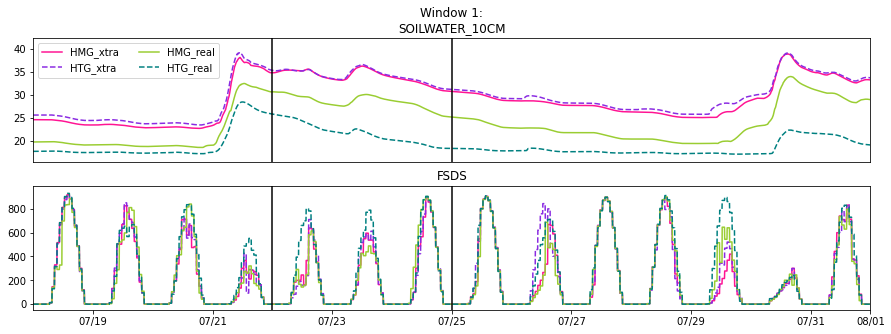

In [221]:
fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window1_HMGartitificialCLM.time.values, window1_HMGartitificialCLM.SOILWATER_10CM.values, 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window1_HTGartitificialCLM.time.values, window1_HTGartitificialCLM.SOILWATER_10CM.values, 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window1_HMGrealCLM.time.values, window1_HMGrealCLM.SOILWATER_10CM.values,
            color='yellowgreen',label='HMG_real')
axs[0].plot(window1_HTGrealCLM.time.values, window1_HTGrealCLM.SOILWATER_10CM.values, 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 1:\nSOILWATER_10CM')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window1_HMGartitificialCLM.time.values, window1_HMGartitificialCLM.FSDS.values, 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window1_HTGartitificialCLM.time.values, window1_HTGartitificialCLM.FSDS.values, 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window1_HMGrealCLM.time.values, window1_HMGrealCLM.FSDS.values,
            color='yellowgreen',label='HMG_real')
axs[1].plot(window1_HTGrealCLM.time.values, window1_HTGrealCLM.FSDS.values, 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('FSDS')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)


axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])


(16634.0, 16648.0)

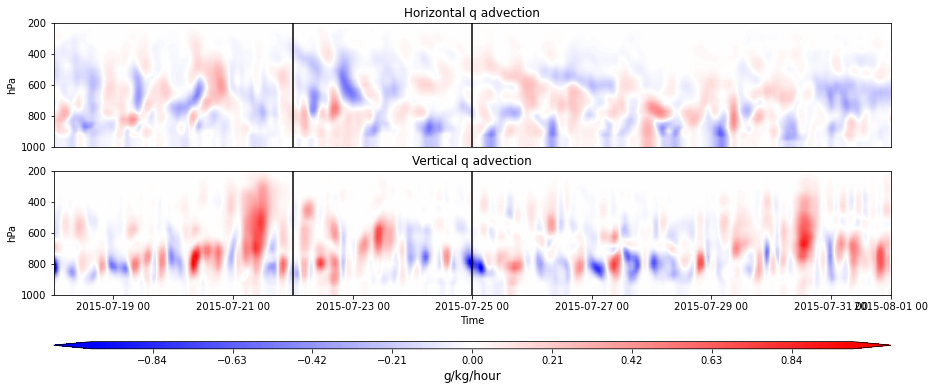

In [222]:
## Plot forcing fields

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.2)

contour_plot   = axs[0].contourf(window1_nateDS.time, window1_nateDS.lev.values, 
                                np.transpose(np.squeeze(window1_nateDS.q_adv_h.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
contour_plot   = axs[1].contourf(window1_nateDS.time, window1_nateDS.lev.values, 
                                np.transpose(np.squeeze(window1_nateDS.q_adv_v.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS.q_adv_h.units,fontsize=12)

axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[0].invert_yaxis()
axs[0].set_title(nateDS.q_adv_h.long_name, fontsize=12)
axs[0].set_ylabel('hPa')
axs[0].set_xlabel('Time')
axs[0].set_ylim([1000,200])

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[1].invert_yaxis()
axs[1].set_title(nateDS.q_adv_v.long_name, fontsize=12)
axs[1].set_ylabel('hPa')
axs[1].set_xlabel('Time')
axs[1].set_ylim([1000,200])

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])


(16634.0, 16648.0)

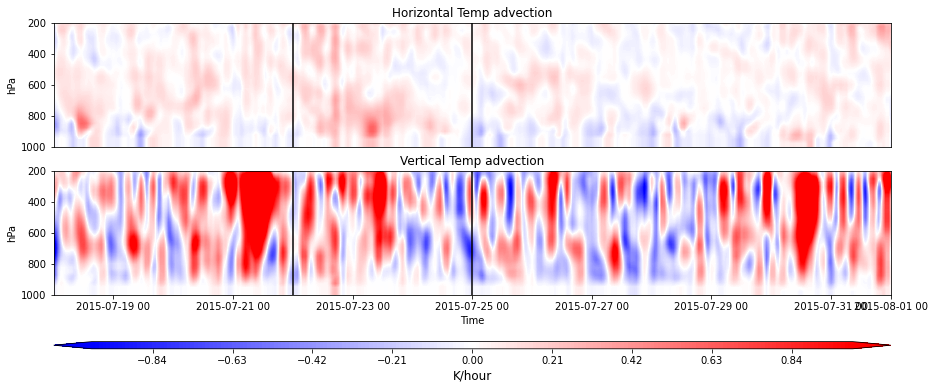

In [223]:
## Plot forcing fields

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.2)

contour_plot   = axs[0].contourf(window1_nateDS.time, window1_nateDS.lev.values, 
                                np.transpose(np.squeeze(window1_nateDS.T_adv_h.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
contour_plot   = axs[1].contourf(window1_nateDS.time, window1_nateDS.lev.values, 
                                np.transpose(np.squeeze(window1_nateDS.T_adv_v.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS.T_adv_h.units,fontsize=12)

axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[0].invert_yaxis()
axs[0].set_title(nateDS.T_adv_h.long_name, fontsize=12)
axs[0].set_ylabel('hPa')
axs[0].set_xlabel('Time')
axs[0].set_ylim([1000,200])

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[1].invert_yaxis()
axs[1].set_title(nateDS.T_adv_v.long_name, fontsize=12)
axs[1].set_ylabel('hPa')
axs[1].set_xlabel('Time')
axs[1].set_ylim([1000,200])

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])


(16634.0, 16648.0)

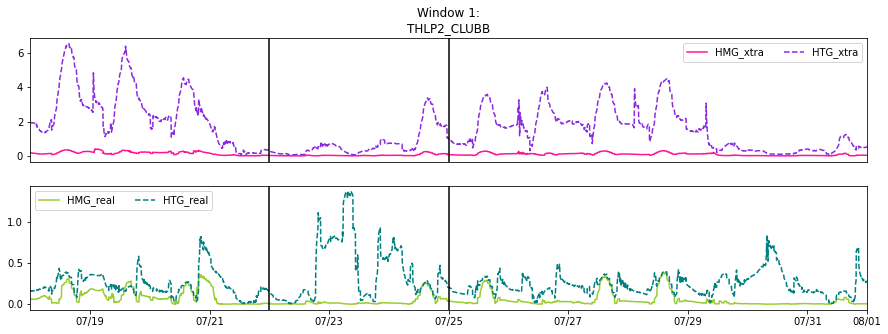

In [224]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.THLP2_CLUBB.values[:,-1,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.THLP2_CLUBB.values[:,-1,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].legend(ncol=2)
axs[0].set_title('Window 1:\nTHLP2_CLUBB')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window1_HMGreal.time.values, window1_HMGreal.THLP2_CLUBB.values[:,-1,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window1_HTGreal.time.values, window1_HTGreal.THLP2_CLUBB.values[:,-1,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2,loc='upper left')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])


(16634.0, 16648.0)

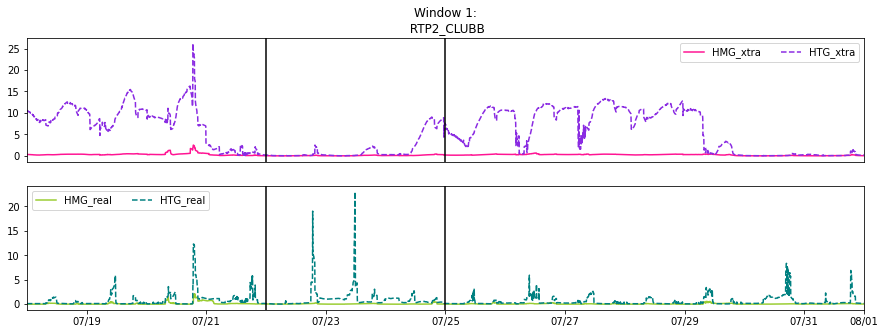

In [225]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.RTP2_CLUBB.values[:,-1,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.RTP2_CLUBB.values[:,-1,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].legend(ncol=2)
axs[0].set_title('Window 1:\n RTP2_CLUBB')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window1_HMGreal.time.values, window1_HMGreal.RTP2_CLUBB.values[:,-1,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window1_HTGreal.time.values, window1_HTGreal.RTP2_CLUBB.values[:,-1,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2,loc='upper left')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])


(16634.0, 16648.0)

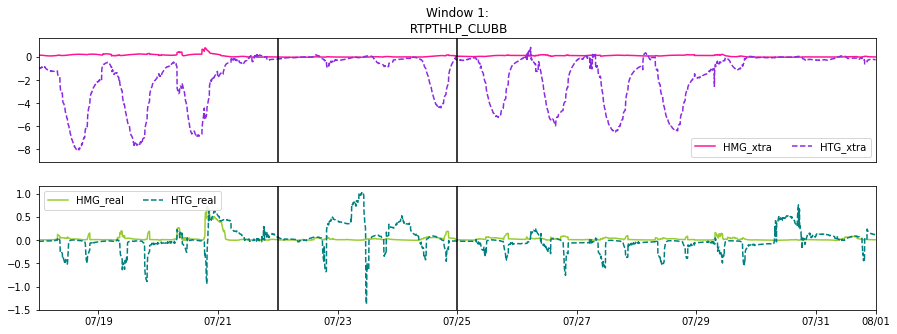

In [226]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window1_HMGartitificial.time.values, window1_HMGartitificial.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window1_HTGartitificial.time.values, window1_HTGartitificial.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].legend(ncol=2)
axs[0].set_title('Window 1:\n RTPTHLP_CLUBB')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window1_HMGreal.time.values, window1_HMGreal.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window1_HTGreal.time.values, window1_HTGreal.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2,loc='upper left')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2015,7,22),color='k')
axs[0].axvline(datetime.date(2015,7,25),color='k')
axs[1].axvline(datetime.date(2015,7,22),color='k')
axs[1].axvline(datetime.date(2015,7,25),color='k')

axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])


**Window 2**

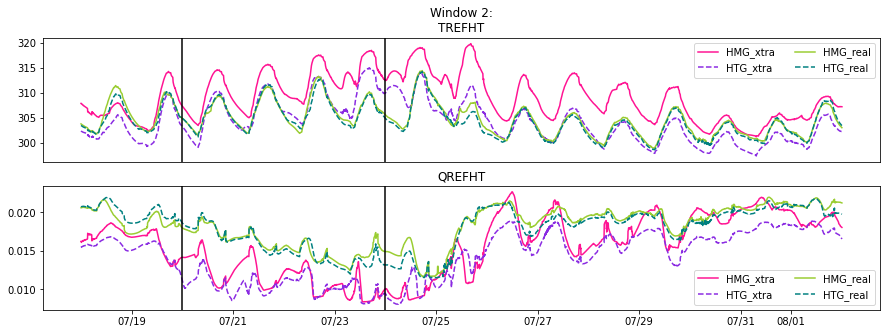

In [260]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.TREFHT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.TREFHT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window2_HMGreal.time.values, window2_HMGreal.TREFHT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window2_HTGreal.time.values, window2_HTGreal.TREFHT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 2:\nTREFHT')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.QREFHT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.QREFHT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window2_HMGreal.time.values, window2_HMGreal.QREFHT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window2_HTGreal.time.values, window2_HTGreal.QREFHT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2)
axs[1].set_title('QREFHT')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])



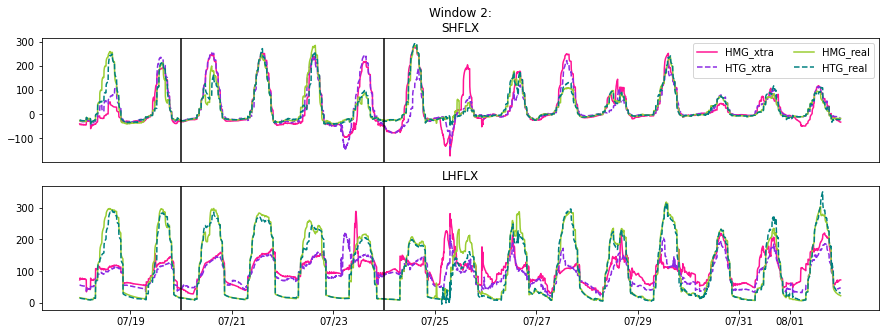

In [261]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.SHFLX.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.SHFLX.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window2_HMGreal.time.values, window2_HMGreal.SHFLX.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window2_HTGreal.time.values, window2_HTGreal.SHFLX.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 2:\nSHFLX')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.LHFLX.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.LHFLX.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window2_HMGreal.time.values, window2_HMGreal.LHFLX.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window2_HTGreal.time.values, window2_HTGreal.LHFLX.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('LHFLX')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])



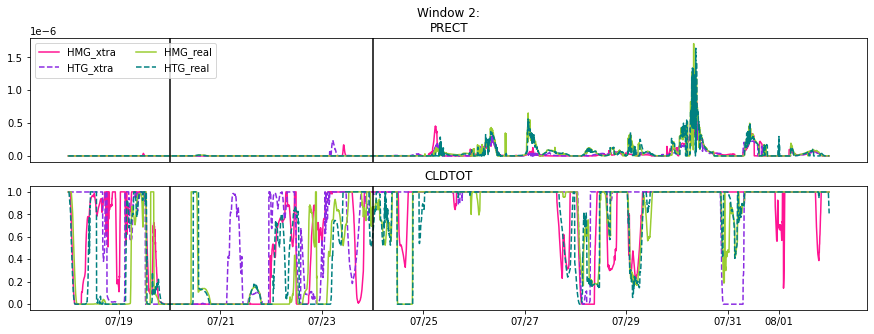

In [262]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.PRECT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.PRECT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window2_HMGreal.time.values, window2_HMGreal.PRECT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window2_HTGreal.time.values, window2_HTGreal.PRECT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 2:\nPRECT')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.CLDTOT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.CLDTOT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window2_HMGreal.time.values, window2_HMGreal.CLDTOT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window2_HTGreal.time.values, window2_HTGreal.CLDTOT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('CLDTOT')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])



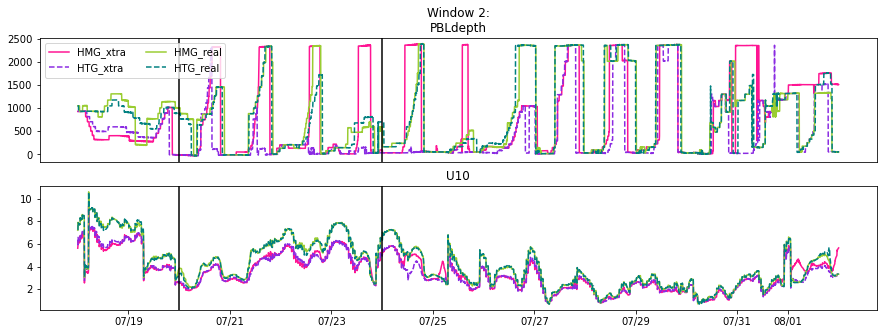

In [263]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.PBLdepth.values, 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.PBLdepth.values, 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window2_HMGreal.time.values, window2_HMGreal.PBLdepth.values, 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window2_HTGreal.time.values, window2_HTGreal.PBLdepth.values, 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 2:\nPBLdepth')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.U10.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.U10.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window2_HMGreal.time.values, window2_HMGreal.U10.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window2_HTGreal.time.values, window2_HTGreal.U10.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('U10')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




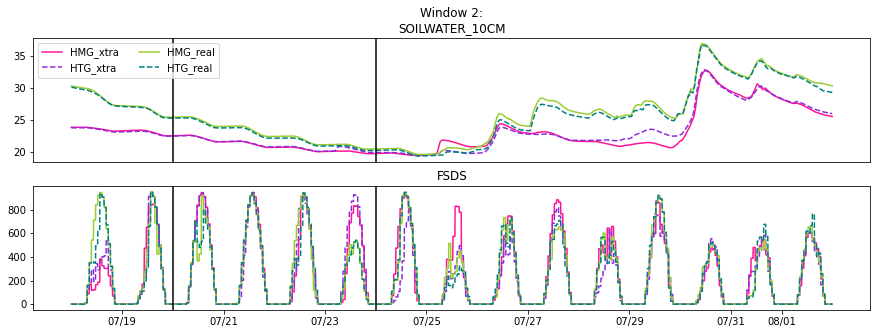

In [264]:
fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window2_HMGartitificialCLM.time.values, window2_HMGartitificialCLM.SOILWATER_10CM.values, 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window2_HTGartitificialCLM.time.values, window2_HTGartitificialCLM.SOILWATER_10CM.values, 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window2_HMGrealCLM.time.values, window2_HMGrealCLM.SOILWATER_10CM.values,
            color='yellowgreen',label='HMG_real')
axs[0].plot(window2_HTGrealCLM.time.values, window2_HTGrealCLM.SOILWATER_10CM.values, 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 2:\nSOILWATER_10CM')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window2_HMGartitificialCLM.time.values, window2_HMGartitificialCLM.FSDS.values, 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window2_HTGartitificialCLM.time.values, window2_HTGartitificialCLM.FSDS.values, 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window2_HMGrealCLM.time.values, window2_HMGrealCLM.FSDS.values,
            color='yellowgreen',label='HMG_real')
axs[1].plot(window2_HTGrealCLM.time.values, window2_HTGrealCLM.FSDS.values, 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('FSDS')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])



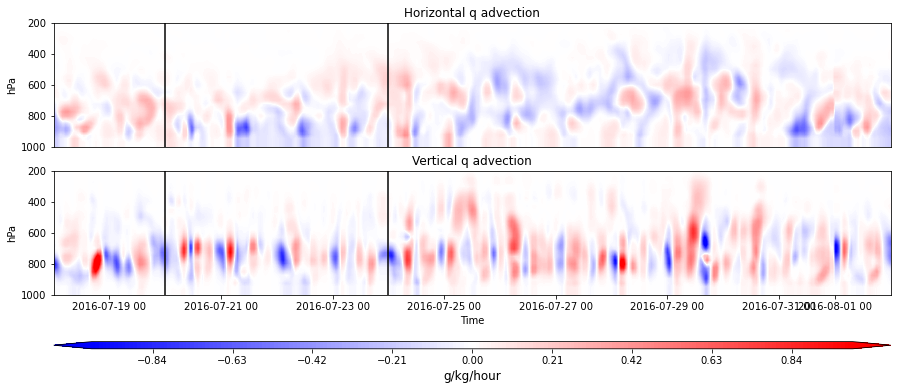

In [265]:
## Plot forcing fields

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.2)

contour_plot   = axs[0].contourf(window2_nateDS.time, window2_nateDS.lev.values, 
                                np.transpose(np.squeeze(window2_nateDS.q_adv_h.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
contour_plot   = axs[1].contourf(window2_nateDS.time, window2_nateDS.lev.values, 
                                np.transpose(np.squeeze(window2_nateDS.q_adv_v.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS.q_adv_h.units,fontsize=12)

axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[0].invert_yaxis()
axs[0].set_title(nateDS.q_adv_h.long_name, fontsize=12)
axs[0].set_ylabel('hPa')
axs[0].set_xlabel('Time')
axs[0].set_ylim([1000,200])

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[1].invert_yaxis()
axs[1].set_title(nateDS.q_adv_v.long_name, fontsize=12)
axs[1].set_ylabel('hPa')
axs[1].set_xlabel('Time')
axs[1].set_ylim([1000,200])

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])



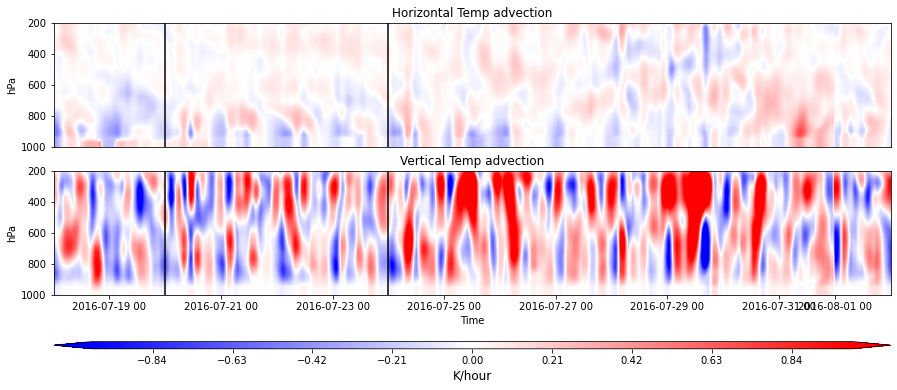

In [266]:
## Plot forcing fields

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.2)

contour_plot   = axs[0].contourf(window2_nateDS.time, window2_nateDS.lev.values, 
                                np.transpose(np.squeeze(window2_nateDS.T_adv_h.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
contour_plot   = axs[1].contourf(window2_nateDS.time, window2_nateDS.lev.values, 
                                np.transpose(np.squeeze(window2_nateDS.T_adv_v.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS.T_adv_h.units,fontsize=12)

axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[0].invert_yaxis()
axs[0].set_title(nateDS.T_adv_h.long_name, fontsize=12)
axs[0].set_ylabel('hPa')
axs[0].set_xlabel('Time')
axs[0].set_ylim([1000,200])

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[1].invert_yaxis()
axs[1].set_title(nateDS.T_adv_v.long_name, fontsize=12)
axs[1].set_ylabel('hPa')
axs[1].set_xlabel('Time')
axs[1].set_ylim([1000,200])

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])



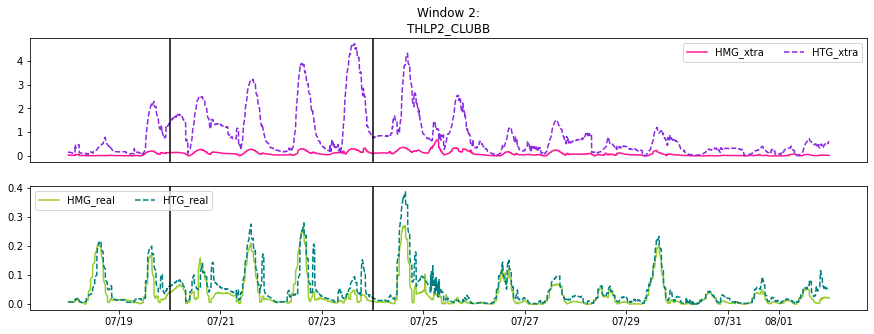

In [267]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.THLP2_CLUBB.values[:,-1,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.THLP2_CLUBB.values[:,-1,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].legend(ncol=2)
axs[0].set_title('Window 2:\nTHLP2_CLUBB')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window2_HMGreal.time.values, window2_HMGreal.THLP2_CLUBB.values[:,-1,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window2_HTGreal.time.values, window2_HTGreal.THLP2_CLUBB.values[:,-1,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2,loc='upper left')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])



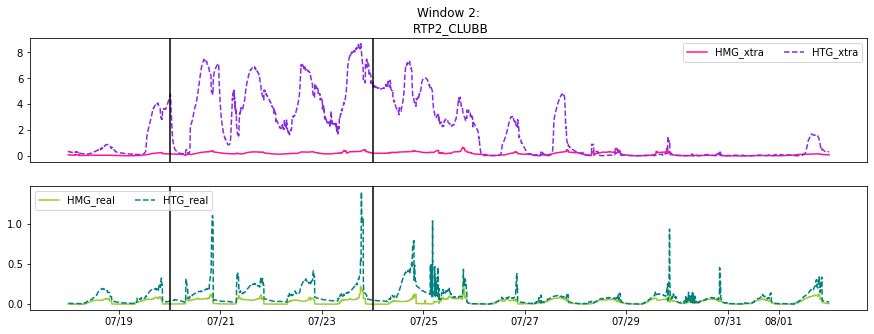

In [268]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.RTP2_CLUBB.values[:,-1,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.RTP2_CLUBB.values[:,-1,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].legend(ncol=2)
axs[0].set_title('Window 2:\n RTP2_CLUBB')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window2_HMGreal.time.values, window2_HMGreal.RTP2_CLUBB.values[:,-1,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window2_HTGreal.time.values, window2_HTGreal.RTP2_CLUBB.values[:,-1,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2,loc='upper left')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])



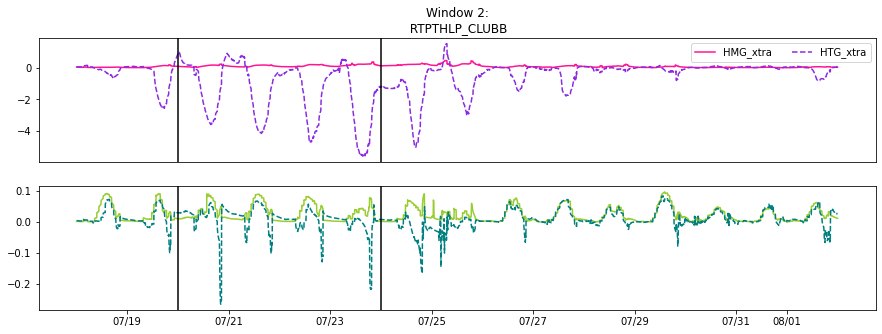

In [269]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window2_HMGartitificial.time.values, window2_HMGartitificial.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window2_HTGartitificial.time.values, window2_HTGartitificial.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].legend(ncol=2)
axs[0].set_title('Window 2:\n RTPTHLP_CLUBB')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window2_HMGreal.time.values, window2_HMGreal.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window2_HTGreal.time.values, window2_HTGreal.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='teal',linestyle='--',label='HTG_real')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2016,7,20),color='k')
axs[0].axvline(datetime.date(2016,7,24),color='k')
axs[1].axvline(datetime.date(2016,7,20),color='k')
axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




**Window 3**

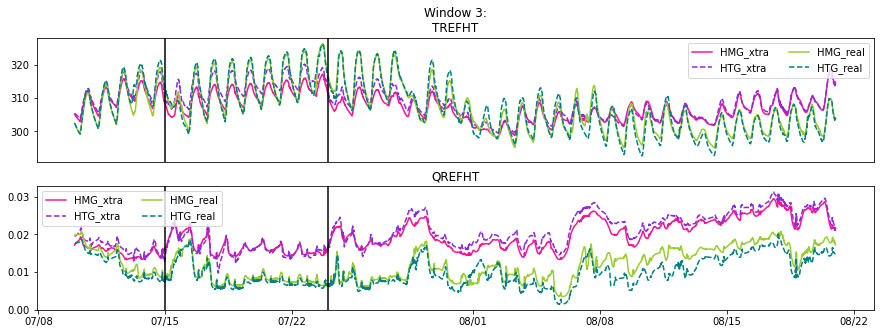

In [290]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.TREFHT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.TREFHT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window3_HMGreal.time.values, window3_HMGreal.TREFHT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window3_HTGreal.time.values, window3_HTGreal.TREFHT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 3:\nTREFHT')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.QREFHT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.QREFHT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window3_HMGreal.time.values, window3_HMGreal.QREFHT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window3_HTGreal.time.values, window3_HTGreal.QREFHT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2)
axs[1].set_title('QREFHT')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

axs[0].axvline(datetime.date(2017,7,15),color='k')
axs[0].axvline(datetime.date(2017,7,24),color='k')
axs[1].axvline(datetime.date(2017,7,15),color='k')
axs[1].axvline(datetime.date(2017,7,24),color='k')



# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




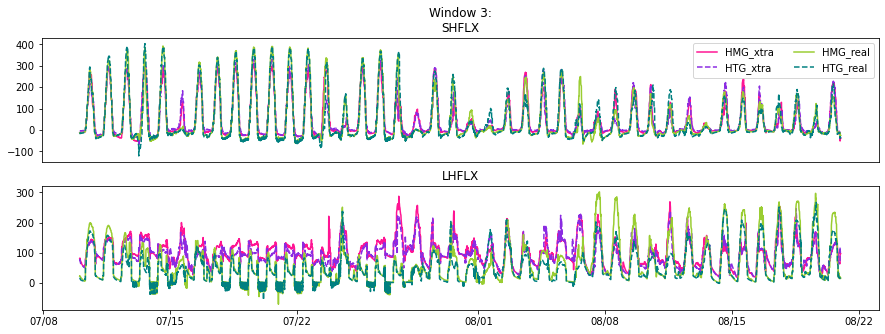

In [279]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.SHFLX.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.SHFLX.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window3_HMGreal.time.values, window3_HMGreal.SHFLX.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window3_HTGreal.time.values, window3_HTGreal.SHFLX.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 3:\nSHFLX')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.LHFLX.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.LHFLX.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window3_HMGreal.time.values, window3_HMGreal.LHFLX.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window3_HTGreal.time.values, window3_HTGreal.LHFLX.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('LHFLX')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

# axs[0].axvline(datetime.date(2016,7,20),color='k')
# axs[0].axvline(datetime.date(2016,7,24),color='k')
# axs[1].axvline(datetime.date(2016,7,20),color='k')
# axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




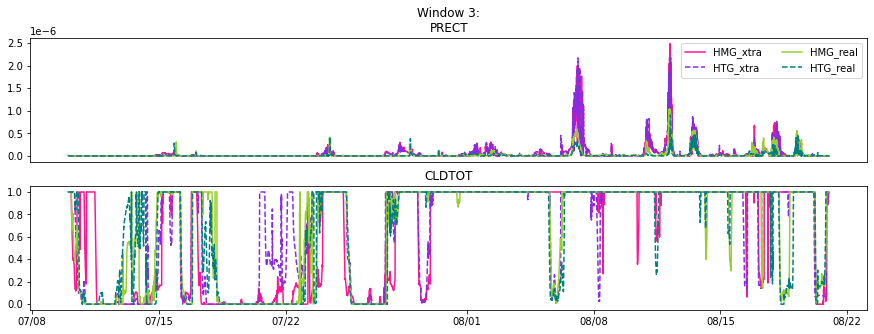

In [280]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.PRECT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.PRECT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window3_HMGreal.time.values, window3_HMGreal.PRECT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window3_HTGreal.time.values, window3_HTGreal.PRECT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 3:\nPRECT')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.CLDTOT.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.CLDTOT.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window3_HMGreal.time.values, window3_HMGreal.CLDTOT.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window3_HTGreal.time.values, window3_HTGreal.CLDTOT.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('CLDTOT')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

# axs[0].axvline(datetime.date(2016,7,20),color='k')
# axs[0].axvline(datetime.date(2016,7,24),color='k')
# axs[1].axvline(datetime.date(2016,7,20),color='k')
# axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




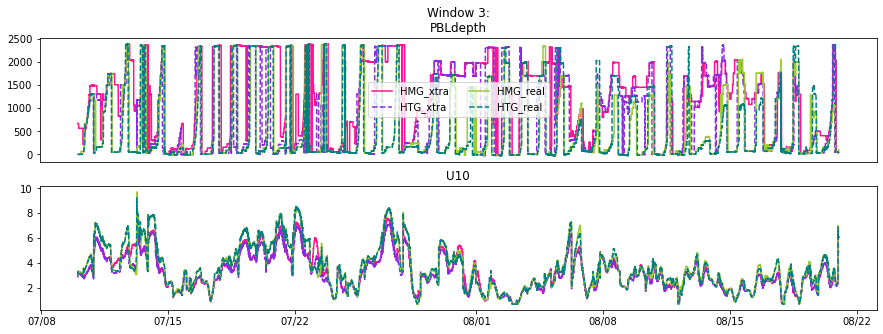

In [281]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.PBLdepth.values, 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.PBLdepth.values, 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window3_HMGreal.time.values, window3_HMGreal.PBLdepth.values, 
            color='yellowgreen',label='HMG_real')
axs[0].plot(window3_HTGreal.time.values, window3_HTGreal.PBLdepth.values, 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 3:\nPBLdepth')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.U10.values[:,0,0], 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.U10.values[:,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window3_HMGreal.time.values, window3_HMGreal.U10.values[:,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window3_HTGreal.time.values, window3_HTGreal.U10.values[:,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('U10')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

# axs[0].axvline(datetime.date(2016,7,20),color='k')
# axs[0].axvline(datetime.date(2016,7,24),color='k')
# axs[1].axvline(datetime.date(2016,7,20),color='k')
# axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])





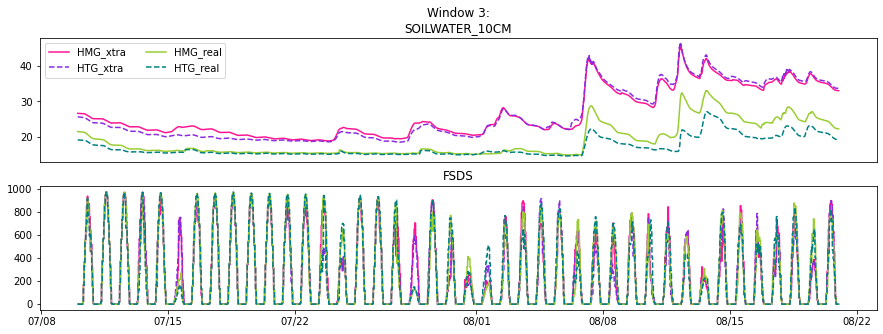

In [282]:
fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window3_HMGartitificialCLM.time.values, window3_HMGartitificialCLM.SOILWATER_10CM.values, 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window3_HTGartitificialCLM.time.values, window3_HTGartitificialCLM.SOILWATER_10CM.values, 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].plot(window3_HMGrealCLM.time.values, window3_HMGrealCLM.SOILWATER_10CM.values,
            color='yellowgreen',label='HMG_real')
axs[0].plot(window3_HTGrealCLM.time.values, window3_HTGrealCLM.SOILWATER_10CM.values, 
            color='teal',linestyle='--',label='HTG_real')
axs[0].legend(ncol=2)
axs[0].set_title('Window 3:\nSOILWATER_10CM')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window3_HMGartitificialCLM.time.values, window3_HMGartitificialCLM.FSDS.values, 
            color='deeppink',label='HMG_xtra')
axs[1].plot(window3_HTGartitificialCLM.time.values, window3_HTGartitificialCLM.FSDS.values, 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[1].plot(window3_HMGrealCLM.time.values, window3_HMGrealCLM.FSDS.values,
            color='yellowgreen',label='HMG_real')
axs[1].plot(window3_HTGrealCLM.time.values, window3_HTGrealCLM.FSDS.values, 
            color='teal',linestyle='--',label='HTG_real')
axs[1].set_title('FSDS')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

# axs[0].axvline(datetime.date(2016,7,20),color='k')
# axs[0].axvline(datetime.date(2016,7,24),color='k')
# axs[1].axvline(datetime.date(2016,7,20),color='k')
# axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




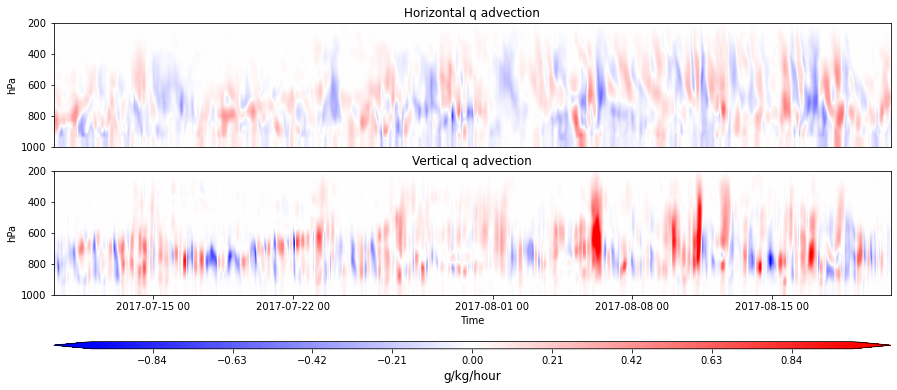

In [283]:
## Plot forcing fields

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.2)

contour_plot   = axs[0].contourf(window3_nateDS.time, window3_nateDS.lev.values, 
                                np.transpose(np.squeeze(window3_nateDS.q_adv_h.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
contour_plot   = axs[1].contourf(window3_nateDS.time, window3_nateDS.lev.values, 
                                np.transpose(np.squeeze(window3_nateDS.q_adv_v.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS.q_adv_h.units,fontsize=12)

axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[0].invert_yaxis()
axs[0].set_title(nateDS.q_adv_h.long_name, fontsize=12)
axs[0].set_ylabel('hPa')
axs[0].set_xlabel('Time')
axs[0].set_ylim([1000,200])

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[1].invert_yaxis()
axs[1].set_title(nateDS.q_adv_v.long_name, fontsize=12)
axs[1].set_ylabel('hPa')
axs[1].set_xlabel('Time')
axs[1].set_ylim([1000,200])

axs[0].get_xaxis().set_visible(False)

# axs[0].axvline(datetime.date(2016,7,20),color='k')
# axs[0].axvline(datetime.date(2016,7,24),color='k')
# axs[1].axvline(datetime.date(2016,7,20),color='k')
# axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




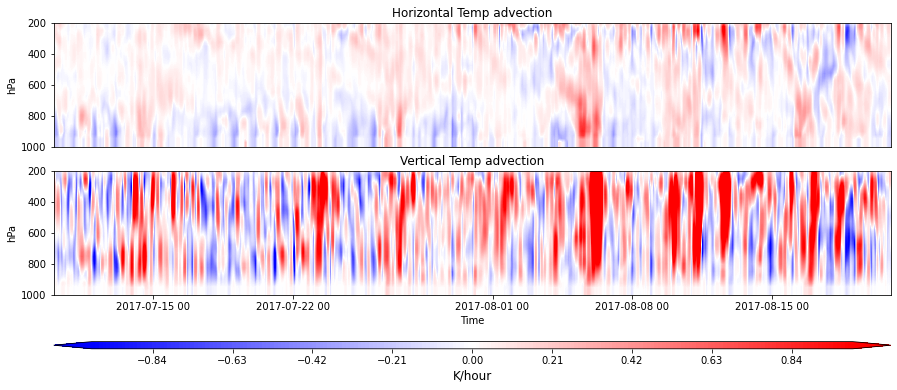

In [284]:
## Plot forcing fields

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.2)

contour_plot   = axs[0].contourf(window3_nateDS.time, window3_nateDS.lev.values, 
                                np.transpose(np.squeeze(window3_nateDS.T_adv_h.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
contour_plot   = axs[1].contourf(window3_nateDS.time, window3_nateDS.lev.values, 
                                np.transpose(np.squeeze(window3_nateDS.T_adv_v.values)),
                                levels=np.arange(-1,1.01,0.01),
                                cmap = 'bwr',
                                extend='both')
    
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.02])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS.T_adv_h.units,fontsize=12)

axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[0].invert_yaxis()
axs[0].set_title(nateDS.T_adv_h.long_name, fontsize=12)
axs[0].set_ylabel('hPa')
axs[0].set_xlabel('Time')
axs[0].set_ylim([1000,200])

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[1].invert_yaxis()
axs[1].set_title(nateDS.T_adv_v.long_name, fontsize=12)
axs[1].set_ylabel('hPa')
axs[1].set_xlabel('Time')
axs[1].set_ylim([1000,200])

axs[0].get_xaxis().set_visible(False)

# axs[0].axvline(datetime.date(2016,7,20),color='k')
# axs[0].axvline(datetime.date(2016,7,24),color='k')
# axs[1].axvline(datetime.date(2016,7,20),color='k')
# axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




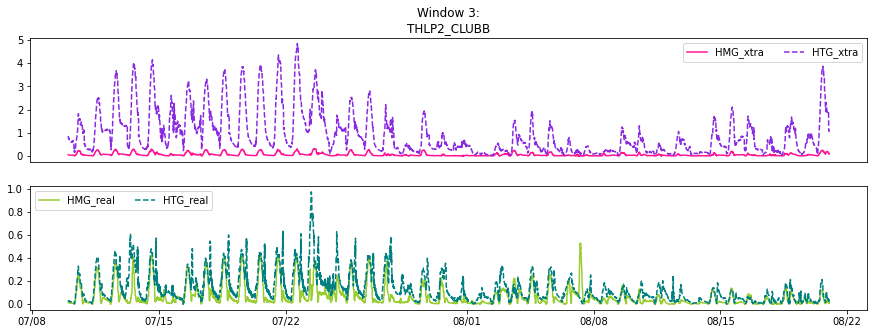

In [286]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.THLP2_CLUBB.values[:,-1,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.THLP2_CLUBB.values[:,-1,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].legend(ncol=2)
axs[0].set_title('Window 3:\nTHLP2_CLUBB')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window3_HMGreal.time.values, window3_HMGreal.THLP2_CLUBB.values[:,-1,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window3_HTGreal.time.values, window3_HTGreal.THLP2_CLUBB.values[:,-1,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2,loc='upper left')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

# axs[0].axvline(datetime.date(2016,7,20),color='k')
# axs[0].axvline(datetime.date(2016,7,24),color='k')
# axs[1].axvline(datetime.date(2016,7,20),color='k')
# axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




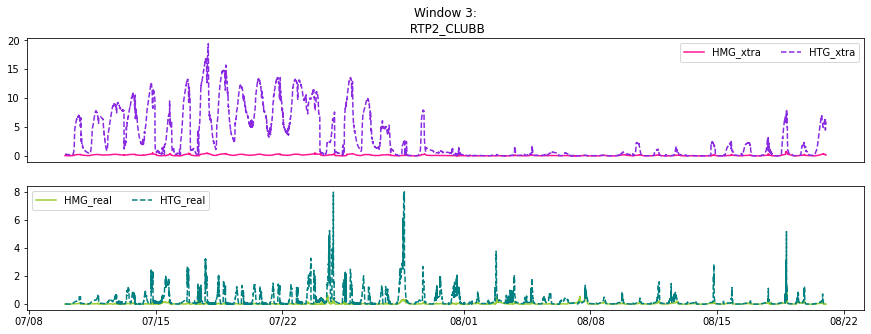

In [287]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.RTP2_CLUBB.values[:,-1,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.RTP2_CLUBB.values[:,-1,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].legend(ncol=2)
axs[0].set_title('Window 3:\n RTP2_CLUBB')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window3_HMGreal.time.values, window3_HMGreal.RTP2_CLUBB.values[:,-1,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window3_HTGreal.time.values, window3_HTGreal.RTP2_CLUBB.values[:,-1,0,0], 
            color='teal',linestyle='--',label='HTG_real')
axs[1].legend(ncol=2,loc='upper left')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

# axs[0].axvline(datetime.date(2016,7,20),color='k')
# axs[0].axvline(datetime.date(2016,7,24),color='k')
# axs[1].axvline(datetime.date(2016,7,20),color='k')
# axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])




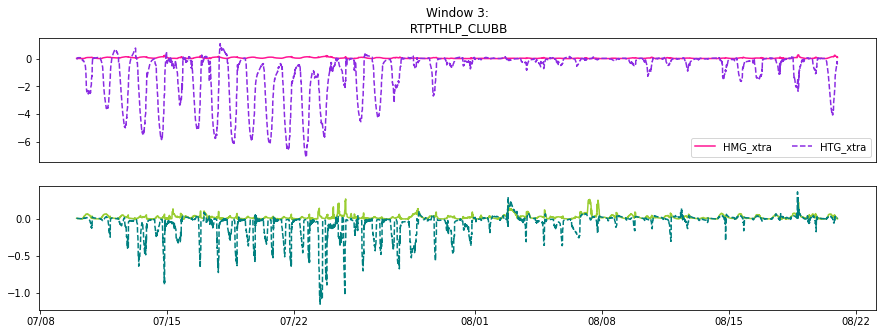

In [288]:
## Plot T/Q differences between simulations 

fig,axs = plt.subplots(2,1, figsize=(15,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2)

axs[0].plot(window3_HMGartitificial.time.values, window3_HMGartitificial.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='deeppink',label='HMG_xtra')
axs[0].plot(window3_HTGartitificial.time.values, window3_HTGartitificial.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='blueviolet',linestyle='--',label='HTG_xtra')
axs[0].legend(ncol=2)
axs[0].set_title('Window 3:\n RTPTHLP_CLUBB')
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 


axs[1].plot(window3_HMGreal.time.values, window3_HMGreal.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='yellowgreen',label='HMG_real')
axs[1].plot(window3_HTGreal.time.values, window3_HTGreal.RTPTHLP_CLUBB.values[:,-1,0,0], 
            color='teal',linestyle='--',label='HTG_real')
# Format the date into months & days
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d')) 

axs[0].get_xaxis().set_visible(False)

# axs[0].axvline(datetime.date(2016,7,20),color='k')
# axs[0].axvline(datetime.date(2016,7,24),color='k')
# axs[1].axvline(datetime.date(2016,7,20),color='k')
# axs[1].axvline(datetime.date(2016,7,24),color='k')

# axs[0].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
# axs[1].set_xlim([datetime.date(2015,7,18), datetime.date(2015,8,1)])
